In [1]:
%pylab inline
from scipy import integrate
import healpy as hp
import camb
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


# Computing the Millennium XXL - LCDM initial power ratio

In [2]:
h=0.6774

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.74, ombh2=0.0223, omch2=0.1188, mnu=0.06, omk=0, tau=0.066)
pars.InitPower.set_params(As=2e-09*(0.8159/0.78835443)**2, ns=0.9667, r=0.0)
#RBeck - here no tensor modes are computed

#Not non-linear corrections couples to smaller scales than you want - RBeck Ok what k to use then?
pars.set_matter_power(redshifts=[1.0/0.104713-1.0], kmax=1500.0)
pars.NonLinear = camb.model.NonLinear_none

results = camb.get_results(pars)
kVect, zVect, p_kVect = results.get_linear_matter_power_spectrum(hubble_units=False, have_power_spectra=True)

In [3]:
import numpy.fft as fft

def loadMilleniumDensity(filePath):

    datafile=open(filePath, 'rb')

    scaleFactor=np.fromfile(datafile, dtype=np.dtype('f4'), count=1, sep='')
    cellNum=np.fromfile(datafile, dtype=np.dtype('i4'), count=1, sep='')

    density=8.0*np.fromfile(datafile, dtype=np.dtype('f4'), count=cellNum[0]**3, sep='').reshape(([cellNum[0]]*3))

    datafile.close()

    return density

pointMassCount=303464448000.0

h_MXXL=0.73

boxSize=3000/h_MXXL # scaling box size in Mpc to 

In [4]:
gridDensities=loadMilleniumDensity('data/MillenniumXXL/density_1024_014.dat') # In count/cell volume
#gridDensities=loadMilleniumDensity('data/MillenniumXXL/density_1024_063.dat') # In count/cell volume

linearGridSize=gridDensities.shape[0]

averageDensity=pointMassCount/(linearGridSize)**3 # In count/cell volume

delta_r_855=gridDensities/averageDensity-1

In [5]:
import os.path

#Power spectrum computation routine
def pk(d, boxsize=500.0,bin2fact=1.0/16.0, filename='',getnuminbin=False,overwrite=True,
       checkmean=False,getxi=False):

    #print filename

    if (os.path.isfile(filename))*(overwrite == False):
        #print 'not calculating'
        p = np.loadtxt(filename)
        kmean = p[:,0]
        pk = p[:,1]
        numinbin = p[:,2]

    else:
        #print 'calculating'

        if (checkmean):
            meanden = np.mean(d.flatten())
            if (meanden != 0.):
                print('Mean = '+str(meanden)+'.  Subtracting it off.')
                d -= meanden
        dk = np.fft.rfftn(d)
        s = d.shape
        sk = dk.shape
        dk2 = (dk*np.conjugate(dk)).astype(np.float64)
        #M.pcolor(np.abs(dk[:,:,0]))

        dk2 = dk2.flatten()
        

        # need to double-count along the z-axis
        
        kmin = 2.*np.pi/boxsize

        if (len(s) == 3):
            a = np.fromfunction(lambda x,y,z:x, sk).astype(np.float64)
            a[np.where(a > s[0]/2)] -= s[0]
            b = np.fromfunction(lambda x,y,z:y, sk).astype(np.float64)
            b[np.where(b > s[1]/2)] -= s[1]
            c = np.fromfunction(lambda x,y,z:z, sk).astype(np.float64)
            c[np.where(c > s[2]/2)] -= s[2]
            # half-count cells on the z-axis

            k = kmin*np.sqrt((a**2+b**2+c**2).flatten()).astype(np.float64)

        elif (len(s) == 2):
            b = np.fromfunction(lambda y,z:y, sk).astype(np.float64)
            b[np.where(b > s[0]/2)] -= s[0]
            c = np.fromfunction(lambda y,z:z, sk).astype(np.float64)
            c[np.where(c > s[1]/2)] -= s[1]

            k = kmin*np.sqrt((b**2+c**2).flatten()).astype(np.float64)
        

        index = np.argsort(k)

        k = k[index]
        dk2 = dk2[index]

        c0 = 0.*c.flatten() + 1.
        c0[np.where(c.flatten() == 0.)] -= 0.5
        c0 = c0[index]

        log2 = np.log(2.)
    
        binedges = kmin*2.**np.arange(-bin2fact/2.,np.log(k[-1]/kmin)/log2,bin2fact)
        cuts = np.searchsorted(k,binedges)
        numinbin = 0.*binedges
        pk = 0.*binedges
        kmean = 0.*binedges
        nbins = len(binedges)

        for i in np.arange(0,nbins-1):
            if (cuts[i+1] > cuts[i]):
                numinbin[i] = np.sum(c0[cuts[i]:cuts[i+1]])
                pk[i] = np.sum(c0[cuts[i]:cuts[i+1]]*dk2[cuts[i]:cuts[i+1]])
                kmean[i] = np.sum(c0[cuts[i]:cuts[i+1]]*k[cuts[i]:cuts[i+1]])

        wn0 = np.where(numinbin > 0.)[0]
        pk = pk[wn0]; kmean = kmean[wn0]; numinbin = numinbin[wn0]
        pk /= numinbin
        kmean /= numinbin

        pk *= boxsize**3/np.prod(np.array(s).astype(np.float64))**2

        if filename != '':
            np.savetxt(filename, np.transpose([kmean,pk,numinbin]))

    if (getnuminbin):
        return kmean,pk,numinbin
    else:
        return kmean,pk

In [6]:
(kEmp_855,p_kEmp_855,numInBin)=pk(delta_r_855,boxsize=boxSize,getnuminbin=True)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


In [7]:
p_kLCDM=interp1d(kVect.astype(np.float64)*h, p_kVect[0,:], kind='cubic', fill_value='extrapolate')(kEmp_855)

np.median(p_kLCDM/p_kEmp_855)

0.86037117794692208

# Load in cosmologies

In [8]:
startScaleFactor=0.104713

speedOfLightSI = 299792458.0 
MpcInMeters = 3.08568025e22
GyrInSeconds = 3.1536e16

speedOfLightMpcGyr = speedOfLightSI/MpcInMeters*GyrInSeconds

CMBTemp=2.726

h=0.6774

In [9]:
def growthFunc(zz,HH):
    # this is the factor to convert the scale-less analytical growth factor to real
    H_zMax_scaleLess = (2.0/3.0*(1.0+zz[-1])**(3.0/2.0))
    ff = 1.0/(HH[-1] / H_zMax_scaleLess )**3 #This is essentially t_0^3 in the EdS formula, fitted at the highest z

    arg_EdS = lambda x: 1.0/(1.0+x)**(7.0/2.0)
    D_zMax_inf_EdS_raw, err = integrate.quad(arg_EdS, zz[-1], np.inf)
    D_zMax_inf_EdS_raw = 27.0/8.0 * D_zMax_inf_EdS_raw

    #print(err)
    
    D_zMax_inf_EdS = ff*D_zMax_inf_EdS_raw

    D_0_z = integrate.cumtrapz(np.divide(1.0+zz,HH**3),zz,initial=0)
    D_0_9 = integrate.trapz(np.divide(1.0+zz,HH**3),zz)

    D1 = HH/HH[0] * \
        (D_0_9 + D_zMax_inf_EdS - D_0_z) \
        / (D_0_9 + D_zMax_inf_EdS)
        
    return D1

In [10]:
class CosmoContainer:
    
    
    def __init__(self, scaleFactorVect, tauVect, D1, onePlusZD1_dtauVect, kVect, p_kVect, H0, omega_m):
        
        self.zCurve_ = 1.0/scaleFactorVect-1.0
        
        self.taus_ = tauVect
        
        self.D1_ = D1
        self.onePlusZD1_dtauVect_ = onePlusZD1_dtauVect
        
        self.H0_SI_ = H0*1000/MpcInMeters
        self.omega_m_ = omega_m
        
        self.kLimits_ = [np.amin(kVect.astype(np.float64)*h),np.amax(kVect.astype(np.float64)*h)]

        self.p_kFunc_ = interp1d(kVect.astype(np.float64)*h, 
                                 p_kVect[0,:]*MpcInMeters**3, 
                                 kind='cubic', 
                                 fill_value='extrapolate')

    def createFromCambResults(scaleFactorVect, cambResults, smoothingSigma, isLinear=True):
        #isLinear==False may require tuning of parameters
        
        zCurve=1.0/scaleFactorVect-1.0
        
        tauVect = cambResults.conformal_time(zCurve)/speedOfLightMpcGyr
        
        hubbleFactors = cambResults.hubble_parameter(zCurve)

        D1_sim=np.flipud(growthFunc(np.flipud(zCurve),np.flipud(hubbleFactors)))

        onePlusZD1_dtau_sim=np.gradient((1.0/scaleFactorVect)*D1_sim,edge_order=2)/np.gradient(tauVect,edge_order=2)

        onePlusZD1_dtau_sim_smooth=gaussian_filter1d(onePlusZD1_dtau_sim,sigma=smoothingSigma, mode='nearest')
    
        if isLinear:
            
            kVect, zVect, p_kVect = cambResults.get_linear_matter_power_spectrum(hubble_units=False, have_power_spectra=True)
            
        else:
            
            kVect, zVect, p_kVect = cambResults.get_matter_power_spectrum(have_power_spectra=True, 
                                                                          minkh=2e-5, 
                                                                          maxkh=1500, 
                                                                          npoints = 500)
            
            p_kVect/=(cambResults.get_params().H0/100)**3
    
        return CosmoContainer(scaleFactorVect, tauVect, D1_sim, onePlusZD1_dtau_sim_smooth, kVect, p_kVect,
                              cambResults.get_params().H0, 
                              cambResults.get_params().omegab+cambResults.get_params().omegac)
    

### Higher resolution LCDM cosmology

In [11]:
sims=['LCDM']

times=[]
scaleFactors=[]
hubbleFactors=[]
omega_m_effs=[]

snapshotNames=[]

for sim in sims:
    globalSimParams=np.genfromtxt('data/timeCurve_'+sim+'.txt',dtype='str')
    
    times.append(np.array([float(f) for f in globalSimParams[:,0]]))
    scaleFactors.append(np.array([float(f) for f in globalSimParams[:,1]]))
    hubbleFactors.append(np.array([float(f) for f in globalSimParams[:,3]]))
    omega_m_effs.append(np.array([float(f) for f in globalSimParams[:,4]]))

    snapshotNames.append(globalSimParams[:,2])


In [12]:
import copy

#aStepSize=0.001
aStepSize=0.00005

aVect=np.flipud(np.arange(1.0,startScaleFactor-aStepSize,-aStepSize))

smoothingSigma=0.01/aStepSize

for i in range(len(sims)):
    times[i]=interp1d(scaleFactors[i], times[i], kind='cubic', fill_value='extrapolate')(aVect)
    hubbleFactors[i]=interp1d(scaleFactors[i], hubbleFactors[i], kind='cubic', fill_value='extrapolate')(aVect)
    omega_m_effs[i]=interp1d(scaleFactors[i], omega_m_effs[i], kind='cubic', fill_value='extrapolate')(aVect)

    scaleFactors[i]=copy.deepcopy(aVect)

    
taus=[]
    
for i in range(len(sims)):
    
    taus.append(3*times[i][0]/scaleFactors[i][0]+integrate.cumtrapz(1.0/scaleFactors[i],times[i],initial=0))

In [13]:
D1_sim=[]
onePlusZD1_dz_sim=[]
onePlusZD1_dz_sim_smooth=[]

onePlusZD1_dtau_sim=[]
onePlusZD1_dtau_sim_smooth=[]

beta_sim=[]
beta_sim_smooth=[]
beta_sim_interp=[]

for i in range(len(sims)):
    
    D1_sim.append(np.flipud(growthFunc(np.flipud(1.0/scaleFactors[i]-1.0),np.flipud(hubbleFactors[i]))))
    
    onePlusZD1_dz_sim.append(np.gradient((1.0/scaleFactors[i])*D1_sim[i],edge_order=2)/
                             np.gradient(1.0/scaleFactors[i]-1.0,edge_order=2))
    
    onePlusZD1_dz_sim_smooth.append(gaussian_filter1d(onePlusZD1_dz_sim[i],sigma=smoothingSigma, mode='nearest'))
  
    onePlusZD1_dtau_sim.append(np.gradient((1.0/scaleFactors[i])*D1_sim[i],edge_order=2)/
                               np.gradient(taus[i],edge_order=2))
    
    onePlusZD1_dtau_sim_smooth.append(gaussian_filter1d(onePlusZD1_dtau_sim[i],sigma=smoothingSigma, mode='nearest'))

    beta_sim.append(np.gradient(np.log(D1_sim[i]),edge_order=2)/np.gradient(np.log(scaleFactors[i]),edge_order=2))
    
    beta_sim_smooth.append(gaussian_filter1d(beta_sim[i],sigma=smoothingSigma, mode='nearest'))
    
    beta_sim_interp.append(interp1d(taus[i], beta_sim_smooth[i], kind='cubic', fill_value='extrapolate'))
    

In [14]:
for i in range(len(sims)):

    times[i][0]=interp1d(scaleFactors[i], 
                         times[i], 
                         kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    hubbleFactors[i][0]=interp1d(scaleFactors[i], 
                                 hubbleFactors[i], 
                                 kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    omega_m_effs[i][0]=interp1d(scaleFactors[i], 
                                omega_m_effs[i], 
                                kind='cubic', fill_value='extrapolate')(startScaleFactor)


    taus[i][0]=interp1d(scaleFactors[i], 
                        taus[i], 
                        kind='cubic', fill_value='extrapolate')(startScaleFactor)

    
    D1_sim[i][0]=interp1d(scaleFactors[i], 
                          D1_sim[i], 
                          kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    onePlusZD1_dz_sim_smooth[i][0]=interp1d(scaleFactors[i], 
                                            onePlusZD1_dz_sim_smooth[i], 
                                            kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    onePlusZD1_dtau_sim_smooth[i][0]=interp1d(scaleFactors[i], 
                                              onePlusZD1_dtau_sim_smooth[i], 
                                              kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    beta_sim_smooth[i][0]=interp1d(scaleFactors[i], 
                                   beta_sim_smooth[i], 
                                   kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    scaleFactors[i][0]=startScaleFactor


In [15]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.74, ombh2=0.0223, omch2=0.1188, mnu=0.06, omk=0, tau=0.066)
pars.InitPower.set_params(As=2e-09*(0.8159/0.78835443)**2, ns=0.9667, r=0.0)
#RBeck - here no tensor modes are computed

#Not non-linear corrections couples to smaller scales than you want - RBeck Ok what k to use then?
pars.set_matter_power(redshifts=[1.0/startScaleFactor-1.0], kmax=1500.0)
pars.NonLinear = camb.model.NonLinear_none

results = camb.get_results(pars)
kVect, zVect, p_kVect = results.get_linear_matter_power_spectrum(hubble_units=False, have_power_spectra=True)

p_kVect_sim=[]

for i in range(len(sims)):

    p_kVect_sim.append(p_kVect*(D1_sim[i][-1]/D1_sim[i][0])**2.0)
    

In [16]:
cosmoContainerDict={}

for i in range(len(sims)):

    cosmoContainerDict[sims[i]+str(aStepSize)]=CosmoContainer(scaleFactors[i], taus[i], 
                                                              D1_sim[i], onePlusZD1_dtau_sim_smooth[i],
                                                              kVect, p_kVect_sim[i], 
                                                              hubbleFactors[i][-1], omega_m_effs[i][-1])

### Regular resolution cosmologies

In [17]:
sims=['BR','LCDM','EdS']
simColors=['blue','red','green']
simLabels=['AvERA','LCDM','EdS']

times=[]
scaleFactors=[]
hubbleFactors=[]
omega_m_effs=[]

snapshotNames=[]

for sim in sims:
    globalSimParams=np.genfromtxt('data/timeCurve_'+sim+'.txt',dtype='str')
    
    times.append(np.array([float(f) for f in globalSimParams[:,0]]))
    scaleFactors.append(np.array([float(f) for f in globalSimParams[:,1]]))
    hubbleFactors.append(np.array([float(f) for f in globalSimParams[:,3]]))
    omega_m_effs.append(np.array([float(f) for f in globalSimParams[:,4]]))

    snapshotNames.append(globalSimParams[:,2])


In [18]:
tags=['320k','625k','1080k']

sims+=['Av320k','Av625k','Av1080k']
simColors+=['Aqua','Turquoise','Teal']
simLabels+=['Av320k','Av625k','Av1080k']

for tag in tags:
    globalSimParams=np.genfromtxt('data/timeCurve_'+tag+'_BR.txt',dtype='str')
    
    times.append(np.array([float(f) for f in globalSimParams[:,0]]))
    scaleFactors.append(np.array([float(f) for f in globalSimParams[:,1]]))
    hubbleFactors.append(np.array([float(f) for f in globalSimParams[:,3]]))
    omega_m_effs.append(np.array([float(f) for f in globalSimParams[:,4]]))

    snapshotNames.append(globalSimParams[:,2])

In [19]:
import copy

aStepSize=0.001
#aStepSize=0.00005

aVect=np.flipud(np.arange(1.0,startScaleFactor-aStepSize,-aStepSize))

smoothingSigma=0.01/aStepSize

for i in range(len(sims)):
    times[i]=interp1d(scaleFactors[i], times[i], kind='cubic', fill_value='extrapolate')(aVect)
    hubbleFactors[i]=interp1d(scaleFactors[i], hubbleFactors[i], kind='cubic', fill_value='extrapolate')(aVect)
    omega_m_effs[i]=interp1d(scaleFactors[i], omega_m_effs[i], kind='cubic', fill_value='extrapolate')(aVect)

    scaleFactors[i]=copy.deepcopy(aVect)

    
taus=[]
    
for i in range(len(sims)):
    
    taus.append(3*times[i][0]/scaleFactors[i][0]+integrate.cumtrapz(1.0/scaleFactors[i],times[i],initial=0))

In [20]:
D1_sim=[]
onePlusZD1_dz_sim=[]
onePlusZD1_dz_sim_smooth=[]

onePlusZD1_dtau_sim=[]
onePlusZD1_dtau_sim_smooth=[]

beta_sim=[]
beta_sim_smooth=[]
beta_sim_interp=[]

for i in range(len(sims)):
    
    D1_sim.append(np.flipud(growthFunc(np.flipud(1.0/scaleFactors[i]-1.0),np.flipud(hubbleFactors[i]))))
    
    onePlusZD1_dz_sim.append(np.gradient((1.0/scaleFactors[i])*D1_sim[i],edge_order=2)/
                             np.gradient(1.0/scaleFactors[i]-1.0,edge_order=2))
    
    onePlusZD1_dz_sim_smooth.append(gaussian_filter1d(onePlusZD1_dz_sim[i],sigma=smoothingSigma, mode='nearest'))
  
    onePlusZD1_dtau_sim.append(np.gradient((1.0/scaleFactors[i])*D1_sim[i],edge_order=2)/
                               np.gradient(taus[i],edge_order=2))
    
    onePlusZD1_dtau_sim_smooth.append(gaussian_filter1d(onePlusZD1_dtau_sim[i],sigma=smoothingSigma, mode='nearest'))

    beta_sim.append(np.gradient(np.log(D1_sim[i]),edge_order=2)/np.gradient(np.log(scaleFactors[i]),edge_order=2))
    
    beta_sim_smooth.append(gaussian_filter1d(beta_sim[i],sigma=smoothingSigma, mode='nearest'))
    
    beta_sim_interp.append(interp1d(taus[i], beta_sim_smooth[i], kind='cubic', fill_value='extrapolate'))
    

In [21]:
for i in range(len(sims)):

    times[i][0]=interp1d(scaleFactors[i], 
                         times[i], 
                         kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    hubbleFactors[i][0]=interp1d(scaleFactors[i], 
                                 hubbleFactors[i], 
                                 kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    omega_m_effs[i][0]=interp1d(scaleFactors[i], 
                                omega_m_effs[i], 
                                kind='cubic', fill_value='extrapolate')(startScaleFactor)


    taus[i][0]=interp1d(scaleFactors[i], 
                        taus[i], 
                        kind='cubic', fill_value='extrapolate')(startScaleFactor)

    
    D1_sim[i][0]=interp1d(scaleFactors[i], 
                          D1_sim[i], 
                          kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    onePlusZD1_dz_sim_smooth[i][0]=interp1d(scaleFactors[i], 
                                            onePlusZD1_dz_sim_smooth[i], 
                                            kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    onePlusZD1_dtau_sim_smooth[i][0]=interp1d(scaleFactors[i], 
                                              onePlusZD1_dtau_sim_smooth[i], 
                                              kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    beta_sim_smooth[i][0]=interp1d(scaleFactors[i], 
                                   beta_sim_smooth[i], 
                                   kind='cubic', fill_value='extrapolate')(startScaleFactor)
    
    scaleFactors[i][0]=startScaleFactor


In [22]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.74, ombh2=0.0223, omch2=0.1188, mnu=0.06, omk=0, tau=0.066)
pars.InitPower.set_params(As=2e-09*(0.8159/0.78835443)**2, ns=0.9667, r=0.0)
#RBeck - here no tensor modes are computed

#Not non-linear corrections couples to smaller scales than you want - RBeck Ok what k to use then?
pars.set_matter_power(redshifts=[1.0/startScaleFactor-1.0], kmax=1500.0)
pars.NonLinear = camb.model.NonLinear_none

results = camb.get_results(pars)
kVect, zVect, p_kVect = results.get_linear_matter_power_spectrum(hubble_units=False, have_power_spectra=True)

p_kVect_sim=[]

for i in range(len(sims)):

    p_kVect_sim.append(p_kVect*(D1_sim[i][-1]/D1_sim[i][0])**2.0)
    

In [23]:
#cosmoContainerDict={}

for i in range(len(sims)):
    
    #sims[i]+str(aStepSize)
    cosmoContainerDict[sims[i]]=CosmoContainer(scaleFactors[i], taus[i], 
                                               D1_sim[i], onePlusZD1_dtau_sim_smooth[i],
                                               kVect, p_kVect_sim[i], 
                                               hubbleFactors[i][-1], omega_m_effs[i][-1])


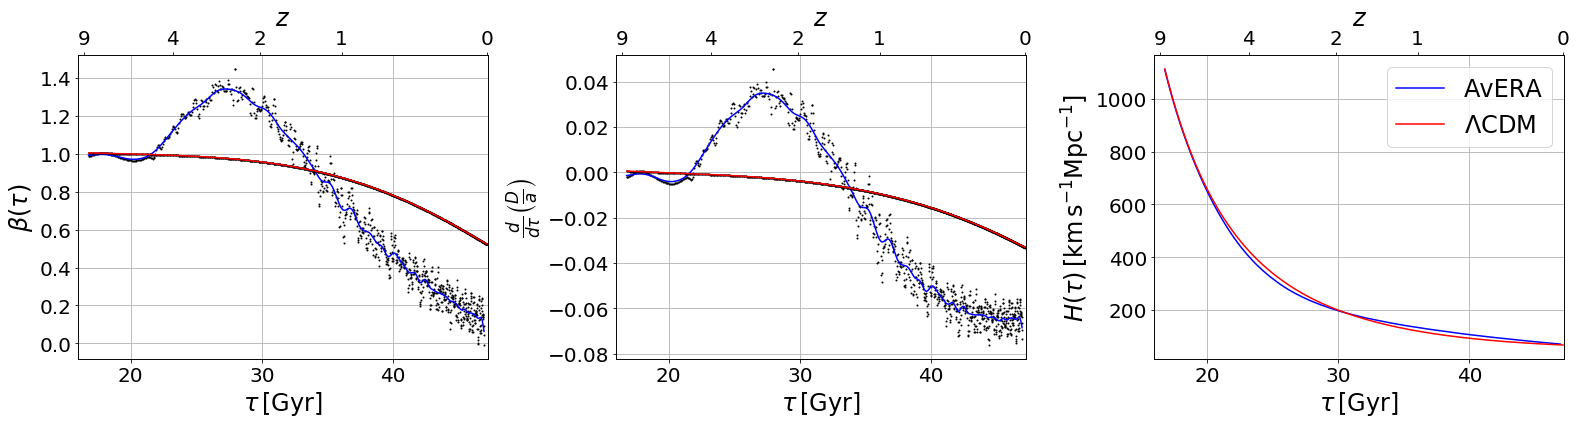

In [24]:
fig = plt.figure(figsize=(22,6))

sims=['BR','LCDM']
simColors=['blue','red']
plotLabels=['AvERA','$\Lambda$CDM']

axs=[]

axs.append(fig.add_subplot(131))
axs.append(fig.add_subplot(132))
axs.append(fig.add_subplot(133))

for i in range(len(axs)):  
    axs[i].set_xlim([16,47.2])
    axs[i].set_xlabel('$\\tau \, [\mathrm{Gyr}]$', fontsize=24)
    axs[i].tick_params(axis='both', labelsize=20)
    axs[i].grid(True)
    
axs[0].set_ylabel('$\\beta(\\tau)$', fontsize=24)

for i in range(len(sims)):
    axs[0].plot(taus[i], beta_sim[i], 'k.', markersize=2)
    axs[0].plot(taus[i], beta_sim_smooth[i], '-', color=simColors[i])

axs[1].set_ylabel('$ \\frac{d}{d\\tau} \\left( \\frac{D}{a} \\right)$', fontsize=24)
    
for i in range(len(sims)):
    axs[1].plot(taus[i], onePlusZD1_dtau_sim[i], 'k.', markersize=2)
    axs[1].plot(taus[i], onePlusZD1_dtau_sim_smooth[i], '-', color=simColors[i])

    
axs[2].set_ylabel('$H(\\tau) \, [\mathrm{km \, s^{-1} Mpc^{-1}}]$', fontsize=24)
    
for i in range(len(sims)):
    axs[2].plot(taus[i], hubbleFactors[i], '-', color=simColors[i], label=plotLabels[i])

axs[2].legend(shadow=False, fancybox=True, fontsize=24, loc=1)


tau_a_func=interp1d(scaleFactors[1], taus[1],  kind='cubic', fill_value='extrapolate')

for ax in axs:
    
    zVals=np.array([9,4,2,1,0])
    
    tauVals=tau_a_func(1.0/(1+zVals))
    
    #"{0:d}".format(zVals)
    
    axTop = ax.twiny()
    axTop.set_xlim(ax.get_xlim())
    
    axTop.set_xticks(tauVals)
    axTop.set_xticklabels(zVals)
    axTop.tick_params(axis='x', labelsize=20)
    axTop.set_xlabel('$z$', fontsize=24)
    
#axs[1].set_xlim([1,100])
#axs[1].set_ylim([0,8])
fig.tight_layout()

fig.savefig('fig/cosmology.pdf', bbox_inches='tight')

In [25]:
#Afshordi 2004

h=0.71

omega_m=0.135/h**2

omega_b=0.0224/h**2

sigma_8=0.84

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=h*100, ombh2=omega_b*h**2, omch2=(omega_m-omega_b)*h**2, omk=0, tau=0.17) #,mnu=0.06, tau=0.066)
pars.InitPower.set_params(As=2e-09*(sigma_8/0.75736669)**2, ns=0.93, r=0.0)


pars.set_matter_power(redshifts=[0.0], kmax=1500.0)

#pars.NonLinear = camb.model.NonLinear_pk
pars.NonLinear = camb.model.NonLinear_none

results = camb.get_results(pars)

cosmoContainerDict['Afshordi2004']=CosmoContainer.createFromCambResults(scaleFactors[1], results, smoothingSigma)

In [26]:
#Francis 2010

h=0.7

omega_m=0.3

omega_b=0.05

sigma_8=0.75

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=h*100, ombh2=omega_b*h**2, omch2=(omega_m-omega_b)*h**2, omk=0) #,mnu=0.06, tau=0.066)
pars.InitPower.set_params(As=2e-09*(sigma_8/0.80682145)**2, ns=1.0, r=0.0)

pars.set_matter_power(redshifts=[0.0], kmax=1500.0)

#pars.NonLinear = camb.model.NonLinear_pk
pars.NonLinear = camb.model.NonLinear_none


results = camb.get_results(pars)

cosmoContainerDict['Francis2010']=CosmoContainer.createFromCambResults(scaleFactors[1], results, smoothingSigma)

# Cosmological power spectrum integrals

In [27]:
def getIndicesInRedshiftRange(zLimits, cosmoCont):
    
    boundaryIndices=np.argmin(abs(cosmoCont.zCurve_.reshape(-1,1)-zLimits),axis=0)
    boundaryIndices.sort()

    return np.arange(boundaryIndices[0],boundaryIndices[1]+1)

def BesselCurve_tau(l,k,cosmoCont):

    tauVect=cosmoCont.taus_
    
    return spherical_jn(l,(tauVect[-1]-tauVect)*speedOfLightMpcGyr*k)


def G_ISW_tau(k,cosmoCont,bessel_tau):
    
    innerIntegrand=cosmoCont.onePlusZD1_dtauVect_*bessel_tau
        
    #The derivative by tau takes the dimension of tauVect
    return -(3*(cosmoCont.H0_SI_**2)/(speedOfLightSI**2)*cosmoCont.omega_m_)*CMBTemp/(k**2)*(MpcInMeters**2)*innerIntegrand


def G_Gal_tau(Pi,b,cosmoCont,bessel_tau):

    innerIntegrand=b*Pi*cosmoCont.D1_*bessel_tau
    
    #The derivative by tau within Pi takes the dimension of tauVect
    return innerIntegrand

def C_lIntegrand(k,cosmoCont,G1,G2):
    
    return (2.0/math.pi)*cosmoCont.p_kFunc_(k)*(k**2)/(MpcInMeters**2)*G1*G2


def C_l_Bessel(lVect, zLimits, kLimits, kRes, cosmoCont, corrType='TT', Pi=None, b=None, returnAsTauFunction=False):

    kVect=np.logspace(np.log10(kLimits[0]),np.log10(kLimits[1]),kRes,base=10)

    withinRange=getIndicesInRedshiftRange(zLimits, cosmoCont)
    
    C_l=[]
    
    for l in lVect:

        outerIntegrand=[]

        for k in kVect:

            bessel_tau=BesselCurve_tau(l,k,cosmoCont)

            if corrType=='TT':

                G2_tau=G_ISW_tau(k,cosmoCont,bessel_tau)

                G1_tau=G2_tau[withinRange]

            elif corrType=='GG':

                G2_tau=G_Gal_tau(Pi,b,cosmoCont,bessel_tau)

                G1_tau=G2_tau[withinRange]

            elif corrType=='GT':

                G2_tau=G_ISW_tau(k,cosmoCont,bessel_tau)

                G1_tau=G_Gal_tau(Pi,b,cosmoCont,bessel_tau)[withinRange]       

            else:

                raise ValueError('Invalid corrType value provided. Valid options: TT, GG and GT')

            if returnAsTauFunction:
                G1=G1_tau           
            else:
                G1=integrate.trapz(G1_tau,cosmoCont.taus_[withinRange])

            G2=integrate.trapz(G2_tau,cosmoCont.taus_)

            outerIntegrand.append(C_lIntegrand(k,cosmoCont,G1,G2))

        C_l.append(integrate.trapz(np.array(outerIntegrand),kVect/MpcInMeters,axis=0))
        
    return np.array(C_l)


In [28]:
def G_ISW_Limber_tau(l,cosmoCont):

    tauVect=cosmoCont.taus_
    
    tau_0=tauVect[-1]
    
    kInv=((tau_0-tauVect)*speedOfLightMpcGyr)/(l+0.5)
    
    #The derivative by tau takes the dimension of tauVect
    return -((3*(cosmoCont.H0_SI_**2)/(speedOfLightSI**2)*cosmoCont.omega_m_)*CMBTemp*(kInv**2)*(MpcInMeters**2)*
             cosmoCont.onePlusZD1_dtauVect_/speedOfLightSI)


def G_Gal_Limber_tau(Pi,b,cosmoCont):

    return b*Pi*cosmoCont.D1_/speedOfLightSI

def C_lIntegrand_Limber(l,cosmoCont,G1,G2):
    
    tauVect=cosmoCont.taus_
    
    tau_0=tauVect[-1]
    
    chi=(tau_0-tauVect)*speedOfLightMpcGyr
    chi[-1]=1.0
    #This is to prevent division by zero. Knocked out by P_k[-1]=0.0 below
    
    P_k=np.empty(len(tauVect))
    
    P_k[:-1]=cosmoCont.p_kFunc_( (l+0.5)/((tau_0-tauVect[:-1])*speedOfLightMpcGyr) )
    P_k[-1]=0.0
    
    return G1*G2/(chi**2)/(MpcInMeters**2)*P_k*speedOfLightSI/GyrInSeconds


def C_l_Limber(lVect, zLimits, cosmoCont, corrType='TT', Pi=None, b=None, returnAsTauFunction=False):

    withinRange=getIndicesInRedshiftRange(zLimits, cosmoCont)
    
    C_l=[]
    
    for l in lVect:

        if corrType=='TT':

            G2_tau=G_ISW_Limber_tau(l,cosmoCont)

            G1_tau=G2_tau

        elif corrType=='GG':

            G2_tau=G_Gal_Limber_tau(Pi,b,cosmoCont)

            G1_tau=G2_tau

        elif corrType=='GT':

            G2_tau=G_ISW_Limber_tau(l,cosmoCont)

            G1_tau=G_Gal_Limber_tau(Pi,b,cosmoCont)

        else:

            raise ValueError('Invalid corrType value provided. Valid options: TT, GG and GT')

        
        C_l_tau=C_lIntegrand_Limber(l,cosmoCont,G1_tau,G2_tau)[withinRange]
            
        if returnAsTauFunction:
            C_l.append(C_l_tau)
        else:
            C_l.append(integrate.trapz(C_l_tau,cosmoCont.taus_[withinRange],axis=0)) 
        
    return np.array(C_l)

In [29]:
def C_l_Switched(lLimitForLimber,lVect, zLimits, kLimits, kRes, cosmoCont, corrType='TT', 
                 Pi=None, b=None, returnAsTauFunction=False):
    
    lVect_Bessel=[]
    lVect_Limber=[]
    
    for l in lVect:
        
        if l>=lLimitForLimber:
            lVect_Limber.append(l)
        else:
            lVect_Bessel.append(l)
    
    C_l=None
    
    if len(lVect_Bessel)>0:
        
        C_l=C_l_Bessel(lVect_Bessel, zLimits, kLimits, kRes, cosmoCont, corrType, Pi, b, returnAsTauFunction)
    
     
    if len(lVect_Limber)>0:
    
        C_l_2=C_l_Limber(lVect_Limber, zLimits, cosmoCont, corrType, Pi, b, returnAsTauFunction)
    
        if C_l is None:
            
            C_l=C_l_2
            
        else:
            
            C_l=np.concatenate((C_l,C_l_2))

    return C_l

# Signal to noise integrals

In [30]:
def SNIntegral(C_TT_CMB, fSky, lLimitForLimber, lVect, zLimits, kLimits, kRes, cosmoCont, Pi, b, returnBeforeSummation=False,
               cosmoCont2=None):
    #C_TT_CMB is expected to be provided for the same l-s that are in lVect
    #If two models are provided, they are expected to have the same tau coverage
    
    C_GT=C_l_Switched(lLimitForLimber, lVect, zLimits, kLimits, kRes, cosmoCont, 'GT', Pi, b, returnAsTauFunction=True)
    C_GG=C_l_Switched(lLimitForLimber, lVect, zLimits, kLimits, kRes, cosmoCont, 'GG', Pi, b, returnAsTauFunction=True)

    if (np.any(C_GT[np.where(C_GG==0.0)]!=0.0)):
    
        raise ValueError('Error - nonzero C_GT, divided by zero C_GG')

    else:
        #All C_GTs are zero where C_GG are zero, setting C_GG to 1 to prevent division by zero
        C_GG[np.where(C_GG==0.0)]=1.0
    
    if cosmoCont2 is not None:
    
        if not np.array_equal(cosmoCont2.zCurve_, cosmoCont.zCurve_):
            
            raise ValueError('Error, the redshift curves of the two provided cosmologies do not match')
    
        C_GT2=C_l_Switched(lLimitForLimber, lVect, zLimits, kLimits, kRes, cosmoCont2, 'GT', Pi, b, returnAsTauFunction=True)
        C_GG2=C_l_Switched(lLimitForLimber, lVect, zLimits, kLimits, kRes, cosmoCont2, 'GG', Pi, b, returnAsTauFunction=True)

        if (np.any(C_GT2[np.where(C_GG2==0.0)]!=0.0)):

            raise ValueError('Error - nonzero C_GT2, divided by zero C_GG2')

        else:
            #All C_GTs are zero where C_GG are zero, setting C_GG to 1 to prevent division by zero
            C_GG2[np.where(C_GG2==0.0)]=1.0

        error1=(C_GG*C_TT_CMB.reshape(-1,1)/(2*lVect.reshape(-1,1)+1.0)/fSky)
        error2=(C_GG2*C_TT_CMB.reshape(-1,1)/(2*lVect.reshape(-1,1)+1.0)/fSky)
   
        SNSqr_l_tau=(C_GT-C_GT2)**2/np.maximum(error1,error2)
        
    else:
    
        SNSqr_l_tau=C_GT*C_GT/(C_GG*C_TT_CMB.reshape(-1,1)/(2*lVect.reshape(-1,1)+1.0)/fSky)

    withinRange=getIndicesInRedshiftRange(zLimits, cosmoCont)
    
    if returnBeforeSummation:
        
        return SNSqr_l_tau
    
    else:
        
        return sqrt(np.sum(integrate.trapz(SNSqr_l_tau, cosmoCont.taus_[withinRange], axis=1), axis=0))
    
    
def SNIntegralWithNoise(zLimitList, ObjCountList, C_TT_CMB, fSky, lLimitForLimber, lVect, kLimits, kRes, cosmoCont, Pi, b,
                        returnBeforeSummation=False, cosmoCont2=None, Pi2=None, b2=None):
    #C_TT_CMB is expected to be provided for the same l-s that are in lVect
    #Pi_tau needs to be normalized to 1 integral (over tau) in each bin of zLimitList
    

    zLimitList=np.array(zLimitList)
    zBoundaries=[np.amin(zLimitList),np.amax(zLimitList)]

    C_GT=C_l_Switched(lLimitForLimber, lVect, zBoundaries, kLimits, kRes, cosmoCont, 'GT', Pi, b, returnAsTauFunction=True)
    C_GG=C_l_Switched(lLimitForLimber, lVect, zBoundaries, kLimits, kRes, cosmoCont, 'GG', Pi, b, returnAsTauFunction=True)

    if cosmoCont2 is not None:
            
        C_GT2=C_l_Switched(lLimitForLimber, lVect, zBoundaries, kLimits, kRes, cosmoCont2, 'GT', Pi2, b2, returnAsTauFunction=True)
        C_GG2=C_l_Switched(lLimitForLimber, lVect, zBoundaries, kLimits, kRes, cosmoCont2, 'GG', Pi2, b2, returnAsTauFunction=True)
    
    SNSqr_l_bin=np.zeros([len(lVect),len(zLimitList)])
    
    for i in range(len(zLimitList)):
    
        if ObjCountList[i]<=0.0:
            
            SNSqr_l_bin[:,i]=0.0
            
        else:
            
            withinRangeBoundary=getIndicesInRedshiftRange(zBoundaries, cosmoCont)

            withinRangeCurrentBin=getIndicesInRedshiftRange(zLimitList[i], cosmoCont)

            #Find matching indices
            indexWithinBoundary=np.searchsorted(withinRangeBoundary, withinRangeCurrentBin)

            C_GT_bin=integrate.trapz(C_GT[:,indexWithinBoundary], cosmoCont.taus_[withinRangeCurrentBin], axis=1)

            C_GG_bin=(integrate.trapz(C_GG[:,indexWithinBoundary], cosmoCont.taus_[withinRangeCurrentBin], axis=1)
                      +4*math.pi*fSky/ObjCountList[i])

            if (np.any(C_GT_bin[np.where(C_GG_bin==0.0)]!=0.0)):

                raise ValueError('Error - nonzero C_GT in bin '+str(i)+', divided by zero C_GG')

            else:
                #All C_GTs are zero where C_GG are zero, setting C_GG to 1 to prevent division by zero
                C_GG_bin[np.where(C_GG_bin==0.0)]=1.0

            if cosmoCont2 is not None:

                withinRangeBoundary=getIndicesInRedshiftRange(zBoundaries, cosmoCont2)

                withinRangeCurrentBin=getIndicesInRedshiftRange(zLimitList[i], cosmoCont2)

                C_GT_bin2=integrate.trapz(C_GT2[:,indexWithinBoundary], cosmoCont2.taus_[withinRangeCurrentBin], axis=1)

                C_GG_bin2=(integrate.trapz(C_GG2[:,indexWithinBoundary], cosmoCont2.taus_[withinRangeCurrentBin], axis=1)
                          +4*math.pi*fSky/ObjCountList[i])

                if (np.any(C_GT_bin2[np.where(C_GG_bin2==0.0)]!=0.0)):

                    raise ValueError('Error - nonzero C_GT2 in bin '+str(i)+', divided by zero C_GG2')

                else:
                    #All C_GTs are zero where C_GG are zero, setting C_GG to 1 to prevent division by zero
                    C_GG_bin2[np.where(C_GG_bin2==0.0)]=1.0

                error1=(C_GG_bin*C_TT_CMB/(2*lVect+1.0)/fSky)
                error2=(C_GG_bin2*C_TT_CMB/(2*lVect+1.0)/fSky)

                SNSqr_l_bin[:,i]=(C_GT_bin-C_GT_bin2)**2/np.maximum(error1,error2)

            else:

                SNSqr_l_bin[:,i]=C_GT_bin*C_GT_bin/(C_GG_bin*C_TT_CMB/(2*lVect+1.0)/fSky)
    
    if returnBeforeSummation:
        
        return SNSqr_l_bin
    
    else:
        
        return sqrt(np.sum(SNSqr_l_bin))


In [31]:
def SetupPiTau(piOption,zLimits,cosmoCont):
    
    zCurve=cosmoCont.zCurve_
    tauCurve=cosmoCont.taus_
        
    withinRange=getIndicesInRedshiftRange(zLimits, cosmoCont)
    
    if piOption==1:
        
        ###Option 1
        #Here we have a uniform dN/dz
        dzCurve=zCurve[1:]-zCurve[:-1]

        dzCentral=np.zeros(len(zCurve))

        for j in range(len(zCurve)):

            if j-1>=0 and j<len(dzCurve):

                dzCentral[j]=(dzCurve[j-1]+dzCurve[j])/2.0

        zRange=np.sum(dzCentral[withinRange])

        Pi_z=np.zeros(len(tauCurve))

        for j in withinRange:

            Pi_z[j]=1.0/zRange

        Pi_tau=Pi_z*np.gradient(zCurve,edge_order=2)/np.gradient(tauCurve,edge_order=2)

    elif piOption==2:
        
        ###Option 2
        #Here Pi_tau is used in place of r^2 n_C, but normalized to be integrated over tau
        Pi_tau=np.zeros(len(tauCurve))

        Pi_tau[withinRange]=1.0

        Pi_tau/=integrate.trapz((tauCurve[-1]-tauCurve)**2*Pi_tau,tauCurve)

        Pi_tau*=(tauCurve[-1]-tauCurve)**2

    elif piOption==3:
        
        ###Option 3
        #Here we use a pre-set dN/dz
        Pi_tau=dN_dzNorm(zCurve,zCutIndex)*np.gradient(zCurve,edge_order=2)/np.gradient(tauCurve,edge_order=2)

    elif piOption==4:
        
        ###Option 4
        #Here we use a Gaussian dN/dz
        mu=(zLimits[1]-zLimits[0])/2.0
        sigma=mu/3.0

        Pi_z=np.zeros(len(zCurve))
        Pi_z[withinRange]=norm.pdf(zCurve[withinRange], loc=mu, scale=sigma)

        Pi_z/=integrate.trapz(Pi_z[withinRange],zCurve[withinRange])

        Pi_tau=Pi_z*np.gradient(zCurve,edge_order=2)/np.gradient(tauCurve,edge_order=2)
    
    else:
        
        raise ValueError('Invalid piOption value provided. Valid options: 1,2,3,4')
        
    return Pi_tau

def SetupPiTauForBinnedSN(piOption,zLimitList,cosmoCont):
    #Setup a Pi_tau that is normalized to 1 integral (over tau) in each bin of zLimitList
    
    zCurve=cosmoCont.zCurve_
    tauCurve=cosmoCont.taus_
    
    if piOption==1:
        ###Option 1
        #Here we have a uniform dN/dz
    
        Pi_z=np.zeros(len(tauCurve))
    
        for i in range(len(zLimitList)):

            withinRangeCurrentBin=getIndicesInRedshiftRange(zLimitList[i], cosmoCont)

            Pi_z[withinRangeCurrentBin[1:-1]]=1.0

            Pi_z[withinRangeCurrentBin]/=integrate.trapz(Pi_z[withinRangeCurrentBin],zCurve[withinRangeCurrentBin])

        Pi_tau=Pi_z*np.gradient(zCurve,edge_order=2)/np.gradient(tauCurve,edge_order=2)
        
    else:
        
        raise ValueError('Invalid piOption value provided. Valid options: 1')
        
    return Pi_tau

# S/N data for appendix B

In [32]:
lVect_Planck=np.arange(2,257)

D_l_Planck_TT=np.loadtxt('data/Planck/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt')[0:len(lVect_Planck),1]/1e12

C_l_Planck_TT=D_l_Planck_TT/(lVect_Planck*(lVect_Planck+1)/(2*math.pi))

In [33]:
containerID1='LCDM'
containerID2='BR'
redshiftRange=[0.0,9.0]

#Pi_tau=SetupPiTau(1,redshiftRange,cosmoContainerDict[containerID])
Pi_tau=np.ones(len(cosmoContainerDict[containerID1].taus_))
b_tau=np.ones(len(Pi_tau))

SN_Ideal_LCDM=SNIntegral(C_l_Planck_TT, 1.0,
                         0, lVect_Planck, redshiftRange, 
                         cosmoContainerDict[containerID1].kLimits_, 1200, 
                         cosmoContainerDict[containerID1], Pi_tau, b_tau,
                         returnBeforeSummation=False)

SN_Ideal_AvERA=SNIntegral(C_l_Planck_TT, 1.0,
                          0, lVect_Planck, redshiftRange, 
                          cosmoContainerDict[containerID2].kLimits_, 1200, 
                          cosmoContainerDict[containerID2], Pi_tau, b_tau,
                          returnBeforeSummation=False)

SN_Ideal_Diff=SNIntegral(C_l_Planck_TT, 1.0,
                         0, lVect_Planck, redshiftRange, 
                         cosmoContainerDict[containerID1].kLimits_, 1200, 
                         cosmoContainerDict[containerID1], Pi_tau, b_tau,
                         returnBeforeSummation=False, cosmoCont2=cosmoContainerDict[containerID2])

print('z=0-9')
print(SN_Ideal_LCDM,SN_Ideal_AvERA,SN_Ideal_Diff)

z=0-9
6.91881915207 27.9847432323 26.3690284623


In [34]:
containerID='LCDM'+str(0.00005)
redshiftRange=[0.0,9.0]

withinRange=getIndicesInRedshiftRange(redshiftRange, cosmoContainerDict[containerID])

#Pi_tau=SetupPiTau(1,redshiftRange,cosmoContainerDict[containerID])
Pi_tau=np.ones(len(cosmoContainerDict[containerID].taus_))
b_tau=np.ones(len(Pi_tau))

print(datetime.datetime.now())
SN_l_tau_highRes2=SNIntegral(C_l_Planck_TT, 1.0, 
                             30, lVect_Planck, redshiftRange, 
                             cosmoContainerDict[containerID].kLimits_, 24000, 
                             cosmoContainerDict[containerID], Pi_tau, b_tau,
                             returnBeforeSummation=True)
print(datetime.datetime.now())

sqrt(np.sum(integrate.trapz(SN_l_tau_highRes2, cosmoContainerDict[containerID].taus_[withinRange], axis=1), axis=0))

2018-05-14 02:37:20.576797
2018-05-14 07:32:47.833982


6.961854650691655

In [35]:
containerID1='LCDM'
containerID2='BR'
redshiftRange=[0.0,1.5]

#Pi_tau=SetupPiTau(1,redshiftRange,cosmoContainerDict[containerID])
Pi_tau=np.ones(len(cosmoContainerDict[containerID1].taus_))
b_tau=np.ones(len(Pi_tau))

SN_Ideal_LCDM=SNIntegral(C_l_Planck_TT, 1.0,
                         0, lVect_Planck, redshiftRange, 
                         cosmoContainerDict[containerID1].kLimits_, 1200, 
                         cosmoContainerDict[containerID1], Pi_tau, b_tau,
                         returnBeforeSummation=False)

SN_Ideal_AvERA=SNIntegral(C_l_Planck_TT, 1.0,
                          0, lVect_Planck, redshiftRange, 
                          cosmoContainerDict[containerID2].kLimits_, 1200, 
                          cosmoContainerDict[containerID2], Pi_tau, b_tau,
                          returnBeforeSummation=False)

SN_Ideal_Diff=SNIntegral(C_l_Planck_TT, 1.0,
                         0, lVect_Planck, redshiftRange, 
                         cosmoContainerDict[containerID1].kLimits_, 1200, 
                         cosmoContainerDict[containerID1], Pi_tau, b_tau,
                         returnBeforeSummation=False, cosmoCont2=cosmoContainerDict[containerID2])

print('z=0-1.5')
print(SN_Ideal_LCDM,SN_Ideal_AvERA,SN_Ideal_Diff)

z=0-1.5
6.35846410705 16.2619616131 11.9856233027


In [36]:
containerID1='LCDM'
containerID2='BR'
redshiftRange=[0.0,1.0]

fSky=1.0
totalObjectNumber=1e7

binWidths=[0.03,0.05,0.1,0.2]

SNList_LCDM=[]
SNList_AvERA=[]
SNList_Diff=[]

for binWidth in binWidths:

    binEdges=np.arange(redshiftRange[0],redshiftRange[1]+1e-10,binWidth)

    zLimitList=[]
    ObjCountList=[]

    for i in range(len(binEdges)-1):

        zLimitList.append([binEdges[i],binEdges[i+1]])

        ObjCountList.append(totalObjectNumber*(binEdges[i+1]-binEdges[i])/(binEdges[-1]-binEdges[0]))


    Pi_tau=SetupPiTauForBinnedSN(1,zLimitList,cosmoContainerDict[containerID1])
    b_tau=np.ones(len(Pi_tau))

    SNSqr_l_bin=SNIntegralWithNoise(zLimitList, ObjCountList, 
                                    C_l_Planck_TT, fSky,
                                    0, lVect_Planck,
                                    cosmoContainerDict[containerID1].kLimits_, 1200, 
                                    cosmoContainerDict[containerID1], 
                                    Pi_tau, b_tau,
                                    returnBeforeSummation=True)

    SNList_LCDM.append(sqrt(np.sum(SNSqr_l_bin)))
    
    Pi_tau2=SetupPiTauForBinnedSN(1,zLimitList,cosmoContainerDict[containerID2])
    b_tau2=np.ones(len(Pi_tau2))
    
    SNSqr_l_bin=SNIntegralWithNoise(zLimitList, ObjCountList, 
                                    C_l_Planck_TT, fSky,
                                    0, lVect_Planck,
                                    cosmoContainerDict[containerID2].kLimits_, 1200, 
                                    cosmoContainerDict[containerID2], 
                                    Pi_tau2, b_tau2,
                                    returnBeforeSummation=True)
    
    SNList_AvERA.append(sqrt(np.sum(SNSqr_l_bin)))
    
    SNSqr_l_bin=SNIntegralWithNoise(zLimitList, ObjCountList, 
                                    C_l_Planck_TT, fSky,
                                    0, lVect_Planck,
                                    cosmoContainerDict[containerID1].kLimits_, 1200, 
                                    cosmoContainerDict[containerID1], 
                                    Pi_tau, b_tau,
                                    returnBeforeSummation=True,
                                    cosmoCont2=cosmoContainerDict[containerID2], Pi2=Pi_tau2, b2=b_tau2)
    
    SNList_Diff.append(sqrt(np.sum(SNSqr_l_bin)))
    
print(SNList_LCDM)
print(SNList_AvERA)
print(SNList_Diff)

[4.327393063139839, 4.3753077107098548, 4.3814336983393165, 4.2839691841492309]
[11.980894107634873, 12.156848200252707, 12.223623688282157, 12.092524774162525]
[8.3821016910982262, 8.5091648635904242, 8.5611527996824641, 8.4949187018034227]


In [37]:
containerID1='LCDM'
containerID2='BR'
redshiftRange=[1.5,4.4]

fSky=1.0

totalObjectNumbers=np.logspace(5,8,100,base=10.0)
binWidths=[0.1,2.9]


SNList_LCDM=[]
SNList_AvERA=[]
SNList_Diff=[]

for binWidth in binWidths:

    SNList_LCDM.append([])
    SNList_AvERA.append([])
    SNList_Diff.append([])
        
    for totalObjectNumber in totalObjectNumbers:
        
        binEdges=np.arange(redshiftRange[0],redshiftRange[1]+1e-10,binWidth)

        zLimitList=[]
        ObjCountList=[]

        for i in range(len(binEdges)-1):

            zLimitList.append([binEdges[i],binEdges[i+1]])

            ObjCountList.append(totalObjectNumber*(binEdges[i+1]-binEdges[i])/(binEdges[-1]-binEdges[0]))


        Pi_tau=SetupPiTauForBinnedSN(1,zLimitList,cosmoContainerDict[containerID1])
        b_tau=np.ones(len(Pi_tau))

        SNSqr_l_bin=SNIntegralWithNoise(zLimitList, ObjCountList, 
                                        C_l_Planck_TT, fSky,
                                        0, lVect_Planck,
                                        cosmoContainerDict[containerID1].kLimits_, 1200, 
                                        cosmoContainerDict[containerID1], 
                                        Pi_tau, b_tau,
                                        returnBeforeSummation=True)

        SNList_LCDM[-1].append(sqrt(np.sum(SNSqr_l_bin)))

        Pi_tau2=SetupPiTauForBinnedSN(1,zLimitList,cosmoContainerDict[containerID2])
        b_tau2=np.ones(len(Pi_tau2))

        SNSqr_l_bin=SNIntegralWithNoise(zLimitList, ObjCountList, 
                                        C_l_Planck_TT, fSky,
                                        0, lVect_Planck,
                                        cosmoContainerDict[containerID2].kLimits_, 1200, 
                                        cosmoContainerDict[containerID2], 
                                        Pi_tau2, b_tau2,
                                        returnBeforeSummation=True)

        SNList_AvERA[-1].append(sqrt(np.sum(SNSqr_l_bin)))

        SNSqr_l_bin=SNIntegralWithNoise(zLimitList, ObjCountList, 
                                        C_l_Planck_TT, fSky,
                                        0, lVect_Planck,
                                        cosmoContainerDict[containerID1].kLimits_, 1200, 
                                        cosmoContainerDict[containerID1], 
                                        Pi_tau, b_tau,
                                        returnBeforeSummation=True,
                                        cosmoCont2=cosmoContainerDict[containerID2], Pi2=Pi_tau2, b2=b_tau2)

        SNList_Diff[-1].append(sqrt(np.sum(SNSqr_l_bin)))


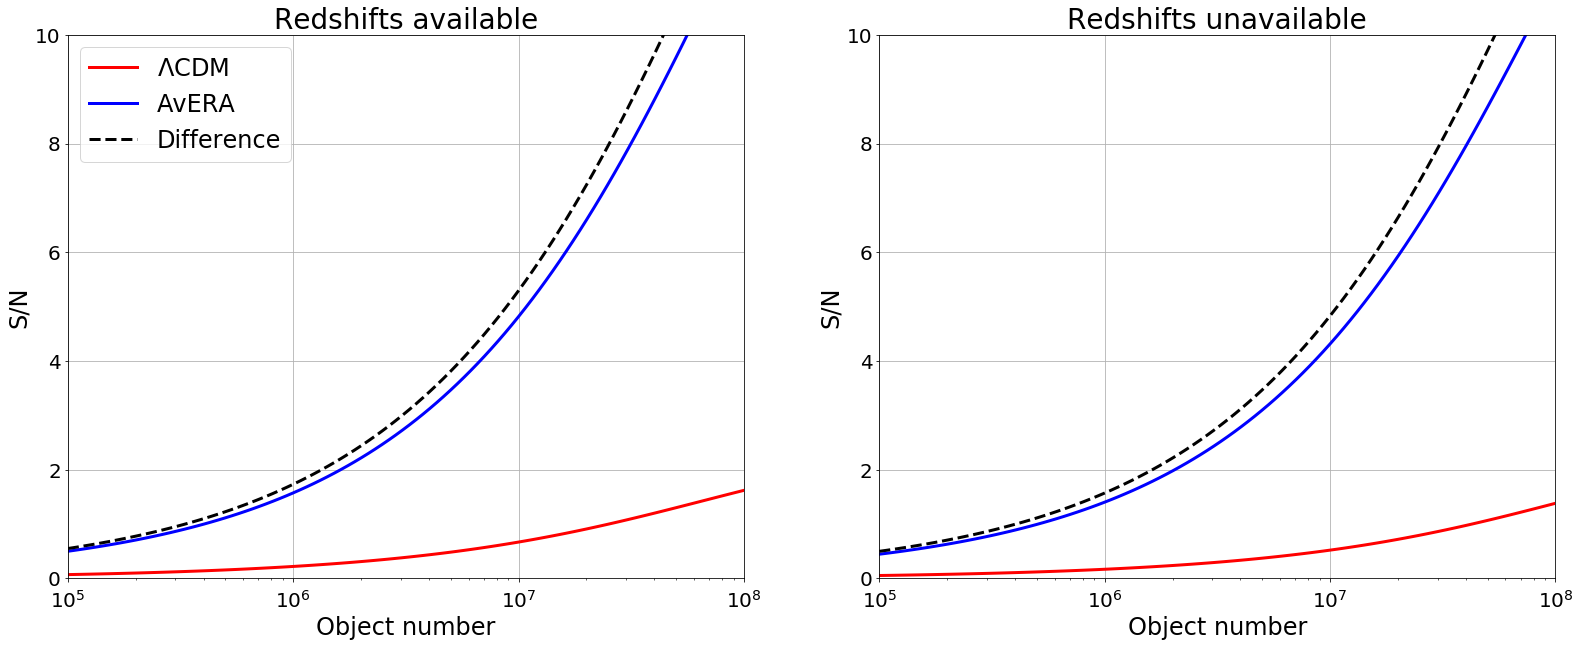

In [38]:
fig = plt.figure(figsize=(26.66,10))

axs=[]

axs.append(fig.add_subplot(121))
axs.append(fig.add_subplot(122))

for i in range(len(axs)):

    ax=axs[i]
    
    ax.set_xlabel('Object number', fontsize=24)
    ax.set_ylabel('S/N', fontsize=24)
    ax.grid(True)
    ax.set_xlim(1e5,1e8)
    ax.set_ylim(0,10)

    #ax.text(35,1.5e-10,'$z=0.48-0.58$', fontsize=20)

    ax.semilogx(totalObjectNumbers, SNList_LCDM[i], '-', linewidth=3.0, color=simColors[1], label=plotLabels[1])
    
    ax.semilogx(totalObjectNumbers, SNList_AvERA[i], '-', linewidth=3.0, color=simColors[0], label=plotLabels[0])

    ax.semilogx(totalObjectNumbers, SNList_Diff[i], '--', linewidth=3.0, color='black', label='Difference')
    
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(axis='x', pad=8)


axs[0].set_title('Redshifts available', fontsize=28)
axs[1].set_title('Redshifts unavailable', fontsize=28)

axs[0].legend(shadow=False, fancybox=True, fontsize=24, loc=2)

fig.savefig('fig/signalToNoise.pdf', bbox_inches='tight')

# Short redshift range integrals

In [39]:
granettISWb_raw=np.loadtxt('data/Granett/ISWpower_Granett2008b.txt')

valueNum=5

granettISWbVals=granettISWb_raw[0:valueNum]

granettISWbError=np.empty((valueNum*2,2))
for i in range(valueNum):
    granettISWbError[2*i]=granettISWb_raw[valueNum+i]
    granettISWbError[2*i+1]=granettISWb_raw[2*valueNum+i]

granettISWbError2=np.loadtxt('data/Granett/ISWpower_Granett2008bb.txt')

In [40]:
redshiftLimit=[0.48,0.58]
sims=['BR','LCDM']
plotLabels=['AvERA','$\Lambda$CDM']

lVect_short=np.arange(1,181)

C_l_scaled_sim_short=[]
C_l_scaled_sim_b_short=[]

for i in range(len(sims)):

    C_l_scaled_sim_short.append(C_l_Limber(lVect_short, redshiftLimit, 
                                           cosmoContainerDict[sims[i]], 'TT',
                                           None, None, returnAsTauFunction=False))
    
    C_l_scaled_sim_b_short.append(C_l_Bessel(lVect_short, redshiftLimit, cosmoContainerDict[sims[i]].kLimits_, 1200, 
                                             cosmoContainerDict[sims[i]], 'TT',
                                             None, None, returnAsTauFunction=False))
    
    C_l_scaled_sim_short[-1]=lVect_short*(lVect_short+1.0)/(2.0*math.pi)*C_l_scaled_sim_short[-1]
    
    C_l_scaled_sim_b_short[-1]=lVect_short*(lVect_short+1.0)/(2.0*math.pi)*C_l_scaled_sim_b_short[-1]

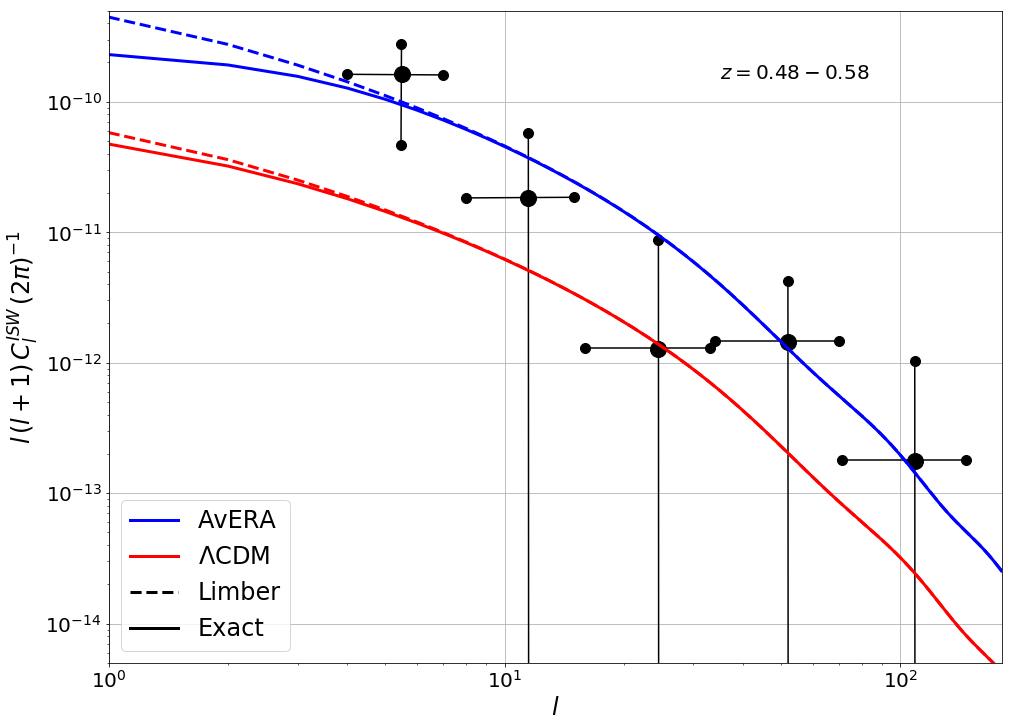

In [41]:
fig = plt.figure(figsize=(16,12))

axs=[]
axs.append(fig.add_subplot(111))

for ax in [axs[0]]:

    ax.set_xlabel('$l$', fontsize=24)
    ax.set_ylabel('$l \, (l+1) \, C^{ISW}_l \, (2\pi)^{-1}$', fontsize=24)
    ax.grid(True)
    ax.set_xlim(1,180)
    ax.set_ylim(5e-15,5e-10)

    ax.text(35,1.5e-10,'$z=0.48-0.58$', fontsize=20)

    ax.loglog(granettISWbVals[:,0],granettISWbVals[:,1]/1e12, 'ko', markersize=16)
    for i in range(valueNum):
        ax.loglog(granettISWbError[(2*i):(2*i+2),0],granettISWbError[(2*i):(2*i+2),1]/1e12, '-ko', markersize=10)
        ax.loglog(granettISWbError2[(2*i):(2*i+2),0],granettISWbError2[(2*i):(2*i+2),1]/1e12, '-ko', markersize=10)
    
    for i in range(len(sims)):

        ax.loglog(lVect_short,C_l_scaled_sim_b_short[i], '-', color=simColors[i], linewidth=3.0, label=plotLabels[i])
        ax.loglog(lVect_short,C_l_scaled_sim_short[i], '--', color=simColors[i], linewidth=3.0)


    ax.loglog(lVect_short,C_l_scaled_sim_short[i]*1e10, '--', color='black', linewidth=3.0, label="Limber")
    ax.loglog(lVect_short,C_l_scaled_sim_short[i]*1e10, '-', color='black', linewidth=3.0, label="Exact")
        
    ax.tick_params(axis='both', labelsize=20)

    ax.legend(shadow=False, fancybox=True, fontsize=24, loc=3)


fig.savefig('fig/newNotebook_Limber1.pdf', bbox_inches='tight')

In [42]:
for i in range(len(sims)):

    C_l_Curve=interp1d(lVect_short, C_l_scaled_sim_b_short[i], kind='cubic', fill_value='extrapolate')

    chiSqr=0.0
    
    for i in range(valueNum):
    
        chiSqr+=((C_l_Curve(granettISWbVals[i,0])-granettISWbVals[i,1]/1e12)/(granettISWbError[2*i+1,1]/1e12-granettISWbVals[i,1]/1e12))**2
    
    print(chiSqr)

1.77013008419
2.00200181466


# Full redshift range integrals

In [43]:
redshiftLimit=[0.0,9.0]
sims=['BR','LCDM']
sims+=['Av320k','Av625k','Av1080k']

lVect=np.arange(1,101)

C_l_scaled_sim=[]
C_l_scaled_sim_b=[]

for i in range(len(sims)):

    C_l_scaled_sim.append(C_l_Limber(lVect, redshiftLimit, 
                                           cosmoContainerDict[sims[i]], 'TT',
                                           None, None, returnAsTauFunction=False))
    
    C_l_scaled_sim_b.append(C_l_Bessel(lVect, redshiftLimit, cosmoContainerDict[sims[i]].kLimits_, 1200, 
                                             cosmoContainerDict[sims[i]], 'TT',
                                             None, None, returnAsTauFunction=False))
    
    C_l_scaled_sim[-1]=lVect*(lVect+1.0)/(2.0*math.pi)*C_l_scaled_sim[-1]
    
    C_l_scaled_sim_b[-1]=lVect*(lVect+1.0)/(2.0*math.pi)*C_l_scaled_sim_b[-1]

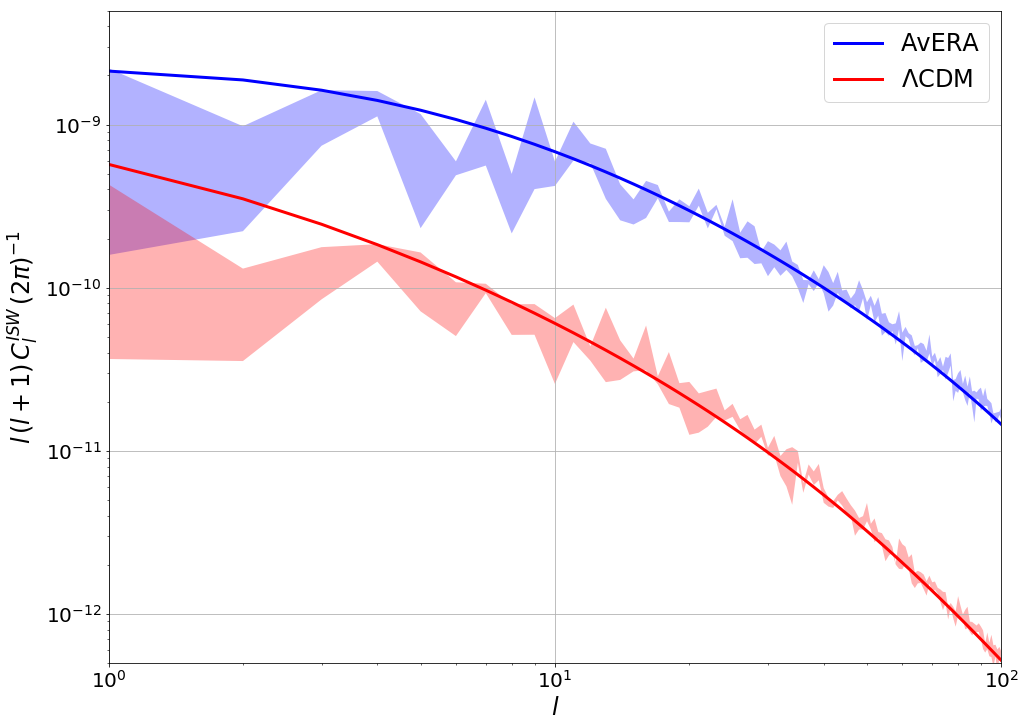

In [44]:
import matplotlib.patches as patches

sims=['BR','LCDM']
plotLabels=['AvERA','$\Lambda$CDM']

outRedshiftList=[0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0,6.0,7.0,8.0]

startPointNum = 3 

healPixResolution=64

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

tag='linear_'
inPath= 'data/ISW_map_lin/'
outPath= 'XXL_'
outRedshiftListFull=outRedshiftList+[8.55]

h_MXXL=0.73

boxSize=3000/h_MXXL

M_pointmass=8.456e9 #*0.73/h #In solar masses

pointMassCount=303464448000.0
    
#Physical units in SI
G_const=6.6740831e-11
M_Sun=1.98892e30

for zId in [len(outRedshiftListFull)-1]: #range(len(outRedshiftListFull)):     
    
    for i in range(len(sims)):
        
        H0_SI=cosmoContainerDict[sims[i]].H0_SI_

        omega_m=cosmoContainerDict[sims[i]].omega_m_            

         
        massPrefactor1=3.0*(H0_SI**2)*omega_m
        massPrefactor2=8.0*math.pi*G_const*pointMassCount*M_pointmass*M_Sun/(boxSize*MpcInMeters)**3
        
        cls=[]
        ell=None
         
        for startID in range(startPointNum):                
        
            deltaT_matrix=np.loadtxt(inPath+outPath+'deltaT_'+tag+sims[i]+'_'+str(startID)+'.txt')
            
            #The factor 0.86037117794692208 scales the Millenium initial power spectrum to the LCDM one
            #The massPrefactor terms scale the average density of the Universe to the theoretical cosmology calculation
            #From CambTest.ipynb
            cls.append(hp.anafast(deltaT_matrix[:,zId+2])*0.86037117794692208*(massPrefactor1/massPrefactor2)**2)
            ell = np.arange(len(cls[-1]))

            #ax.loglog(ell, ell * (ell+1) * cl / 2.0 / np.pi, '--')

        cls=np.array(cls)
            
        xyPolygon=[]

        for j in range(len(ell)):

            xyPolygon.append([ell[j],ell[j] * (ell[j]+1) * np.amax(cls[:,j]) / 2.0 / np.pi])

        for j in reversed(range(len(ell))):

            xyPolygon.append([ell[j],ell[j] * (ell[j]+1) * np.amin(cls[:,j]) / 2.0 / np.pi])

        j=0
        xyPolygon.append([ell[j],ell[j] * (ell[j]+1) * np.amax(cls[:,j]) / 2.0 / np.pi])

        xyPolygon=np.array(xyPolygon)


        ax.add_patch(patches.Polygon(xyPolygon,
                                     closed=True,
                                     alpha=0.3,
                                     facecolor=simColors[i],
                                     fill=True))
            
    ax.set_xlabel('$l$', fontsize=24)
    ax.set_ylabel('$l \, (l+1) \, C^{ISW}_l \, (2\pi)^{-1}$', fontsize=24)
    ax.grid(True)
    ax.set_xlim(1,100)
    ax.set_ylim(5e-13,5e-9)

    for i in range(len(sims)):

        ax.loglog(lVect,C_l_scaled_sim_b[i], '-', color=simColors[i], linewidth=3.0, label=plotLabels[i])


    ax.tick_params(axis='both', labelsize=20)

    ax.legend(shadow=False, fancybox=True, fontsize=24, loc=1)
    
    fig.savefig('fig/newNotebook_ISWPowerFinal.pdf', bbox_inches='tight')

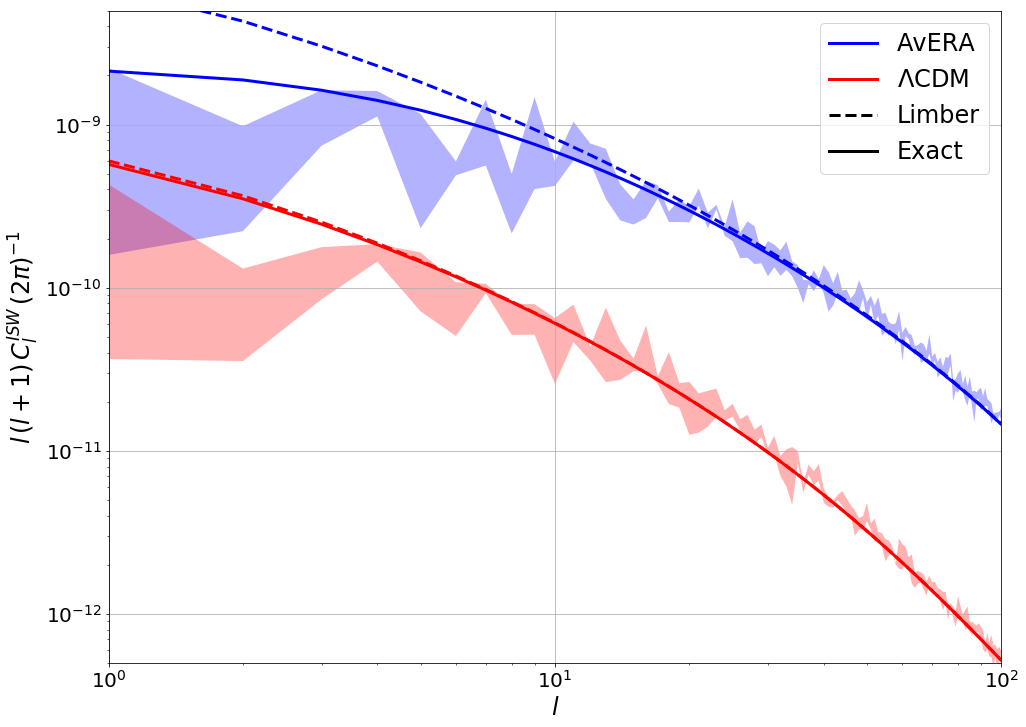

In [45]:
import matplotlib.patches as patches

sims=['BR','LCDM']
plotLabels=['AvERA','$\Lambda$CDM']

outRedshiftList=[0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0,6.0,7.0,8.0]

startPointNum = 3 

healPixResolution=64

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

tag='linear_'
inPath= 'data/ISW_map_lin/'
outPath= 'XXL_'
outRedshiftListFull=outRedshiftList+[8.55]

h_MXXL=0.73

boxSize=3000/h_MXXL

M_pointmass=8.456e9 #*0.73/h #In solar masses

pointMassCount=303464448000.0
    
#Physical units in SI
G_const=6.6740831e-11
M_Sun=1.98892e30

for zId in [len(outRedshiftListFull)-1]: #range(len(outRedshiftListFull)):     
    
    for i in range(len(sims)):
        
        H0_SI=cosmoContainerDict[sims[i]].H0_SI_

        omega_m=cosmoContainerDict[sims[i]].omega_m_            

         
        massPrefactor1=3.0*(H0_SI**2)*omega_m
        massPrefactor2=8.0*math.pi*G_const*pointMassCount*M_pointmass*M_Sun/(boxSize*MpcInMeters)**3
        
        cls=[]
        ell=None
         
        for startID in range(startPointNum):                
        
            deltaT_matrix=np.loadtxt(inPath+outPath+'deltaT_'+tag+sims[i]+'_'+str(startID)+'.txt')

            #The factor 0.86037117794692208 scales the Millenium initial power spectrum to the LCDM one
            #The massPrefactor terms scale the average density of the Universe to the theoretical cosmology calculation
            #From CambTest.ipynb
            cls.append(hp.anafast(deltaT_matrix[:,zId+2])*0.86037117794692208*(massPrefactor1/massPrefactor2)**2)
            ell = np.arange(len(cls[-1]))

            #ax.loglog(ell, ell * (ell+1) * cl / 2.0 / np.pi, '--')

        cls=np.array(cls)
            
        xyPolygon=[]

        for j in range(len(ell)):

            xyPolygon.append([ell[j],ell[j] * (ell[j]+1) * np.amax(cls[:,j]) / 2.0 / np.pi])

        for j in reversed(range(len(ell))):

            xyPolygon.append([ell[j],ell[j] * (ell[j]+1) * np.amin(cls[:,j]) / 2.0 / np.pi])

        j=0
        xyPolygon.append([ell[j],ell[j] * (ell[j]+1) * np.amax(cls[:,j]) / 2.0 / np.pi])

        xyPolygon=np.array(xyPolygon)


        ax.add_patch(patches.Polygon(xyPolygon,
                                     closed=True,
                                     alpha=0.3,
                                     facecolor=simColors[i],
                                     fill=True))
            
    ax.set_xlabel('$l$', fontsize=24)
    ax.set_ylabel('$l \, (l+1) \, C^{ISW}_l \, (2\pi)^{-1}$', fontsize=24)
    ax.grid(True)
    ax.set_xlim(1,100)
    ax.set_ylim(5e-13,5e-9)

    for i in range(len(sims)):

        ax.loglog(lVect,C_l_scaled_sim_b[i], '-', color=simColors[i], linewidth=3.0, label=plotLabels[i])
        ax.loglog(lVect,C_l_scaled_sim[i], '--', color=simColors[i], linewidth=3.0)

    ax.loglog(lVect,C_l_scaled_sim[i]*1e10, '--', color='black', linewidth=3.0, label="Limber")
    ax.loglog(lVect,C_l_scaled_sim[i]*1e10, '-', color='black', linewidth=3.0, label="Exact")
        
    ax.tick_params(axis='both', labelsize=20)

    ax.legend(shadow=False, fancybox=True, fontsize=24, loc=1)
    
    fig.savefig('fig/newNotebook_Limber2.pdf', bbox_inches='tight')

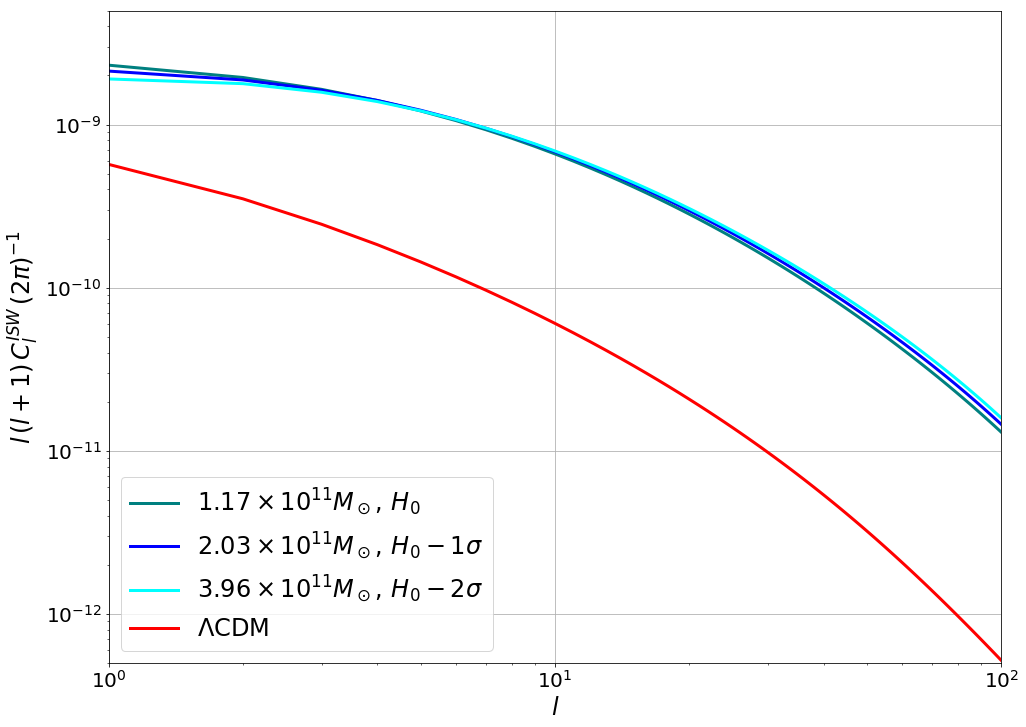

In [46]:
sims=['BR','LCDM']
plotLabels=['AvERA','$\Lambda$CDM']
simColors=['blue','red']

sims+=['Av320k','Av625k','Av1080k']
simColors+=['Aqua','Blue','Teal']

plotLabels+=['$3.96 \\times 10^{11} M_\odot, \, H_0-2\sigma$',
             '$2.03 \\times 10^{11} M_\odot, \, H_0-1\sigma$',
             '$1.17 \\times 10^{11} M_\odot, \, H_0$']

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)
            
ax.set_xlabel('$l$', fontsize=24)
ax.set_ylabel('$l \, (l+1) \, C^{ISW}_l \, (2\pi)^{-1}$', fontsize=24)
ax.grid(True)
ax.set_xlim(1,100)
ax.set_ylim(5e-13,5e-9)

for i in reversed(range(1,len(sims))):

    ax.loglog(lVect,C_l_scaled_sim_b[i], '-', color=simColors[i], linewidth=3.0, label=plotLabels[i])


ax.tick_params(axis='both', labelsize=20)

ax.legend(shadow=False, fancybox=True, fontsize=24, loc=3)

fig.savefig('fig/newNotebook_ParticleMass.pdf', bbox_inches='tight')

# Literature comparison data

In [47]:
AValues=[]
lRanges=[]
labels=[]
edgecolors=[]
edgestyles=[]
facecolors=[]

sdssColor='blue'
wiseColor='xkcd:olive green'
desColor='purple'
mixedColor='xkcd:neon green'

#brown pink olive cyan

corrEdgeColor='black'
stackingEdgeColor='black'

corrEdgeStyle='dashed'
stackingEdgeStyle='solid'

alphaValue=0.1

#deg=180/l
#zero degrees plotted till 2500
#zero l plotted till 1

AValues.append([1.24,0.27])
lRanges.append([180.0/12,180.0/0.25])
labels.append('Giannantonio2008') #https://arxiv.org/pdf/0801.4380.pdf
facecolors.append(mixedColor)

AValues.append([1.38,0.32])
lRanges.append([180.0/12,180.0/0.25])
labels.append('Giannantonio2012') #https://arxiv.org/pdf/1209.2125.pdf
facecolors.append(mixedColor)

AValues.append([2.23,0.60])
lRanges.append([6,180]) 
labels.append('Ho2008') #https://arxiv.org/pdf/0801.0642.pdf
facecolors.append(mixedColor)

AValues.append([2.51,1.25])
lRanges.append([1,20])
labels.append('Granett2009') #https://arxiv.org/pdf/0812.1025.pdf
facecolors.append(sdssColor)

AValues.append([1.74,1.46])
lRanges.append([4,192])
labels.append('Granett2009') #https://arxiv.org/pdf/0812.1025.pdf
facecolors.append(sdssColor)

AValues.append([0.8,0.9])
lRanges.append([5,100]) 
labels.append('Kovacs2013') #https://arxiv.org/pdf/1301.0475.pdf
facecolors.append(wiseColor)

AValues.append([1.24,0.47])
lRanges.append([10,100]) 
labels.append('Ferraro2015') #https://arxiv.org/pdf/1401.1193.pdf
facecolors.append(wiseColor)

AValues.append([0.88,0.74])
lRanges.append([10,100]) 
labels.append('Ferraro2015') #https://arxiv.org/pdf/1401.1193.pdf
facecolors.append(wiseColor)

AValues.append([1.18,0.36])
lRanges.append([2,100]) 
labels.append('Shajib2016') #https://arxiv.org/pdf/1604.03939.pdf
facecolors.append(wiseColor)

AValues.append([0.64,0.74])
lRanges.append([2,100])
labels.append('Shajib2016') #https://arxiv.org/pdf/1604.03939.pdf
facecolors.append(wiseColor)

AValues.append([3.4,1.1])
lRanges.append([6,87])
labels.append('Goto2012') #https://arxiv.org/pdf/1202.5306.pdf
facecolors.append(wiseColor)

AValues.append([2.4,1.0])
lRanges.append([10,75])
labels.append('Granett2015') #https://arxiv.org/pdf/1507.03914.pdf
facecolors.append(sdssColor)

AValues.append([1.0,0.25])
lRanges.append([8,40])
labels.append('Planck2015') #https://arxiv.org/pdf/1502.01595.pdf
facecolors.append(mixedColor)

for i in range(len(AValues)):
    edgecolors.append(corrEdgeColor)
    edgestyles.append(corrEdgeStyle)

AValues.append([9.6/4.2,2.2/4.2]) #No error bar for LCDM prediction
lRanges.append([22,49])
labels.append('Granett2008') #https://arxiv.org/pdf/0805.3695.pdf
facecolors.append(sdssColor)

AValues.append([(2.9+9.3)/2.0,9.3-(2.9+9.3)/2.0])
lRanges.append([12,128])
labels.append('Papai2011') #https://arxiv.org/pdf/1012.3750.pdf
facecolors.append(sdssColor)

AValues.append([5.4,2.2]) # Not sure about this
lRanges.append([10,128])
labels.append('Granett2015') #https://arxiv.org/pdf/1507.03914.pdf
facecolors.append(sdssColor)

#14-29 at 150 Mpc/h
#21-44 at 100 Mpc/h
#35-74 at 60 Mpc/h
#110-226 at 20 Mpc/h
AValues.append([6.0,6.0/2.3])
lRanges.append([14,226])
labels.append('Cai2017') #https://arxiv.org/pdf/1609.00301.pdf
facecolors.append(sdssColor)

AValues.append([20.0,20.0/3.7])
lRanges.append([14,74])
labels.append('Cai2017') #https://arxiv.org/pdf/1609.00301.pdf
facecolors.append(sdssColor)

#9-19
#97-197
AValues.append([8.0,6.0])
lRanges.append([10,197])
labels.append('Kovacs2017') #https://arxiv.org/pdf/1610.00637.pdf
facecolors.append(desColor)

#15-32
#126-308
AValues.append([16.0,8.0])
lRanges.append([15,308])
labels.append('Kovacs2017') #https://arxiv.org/pdf/1610.00637.pdf
facecolors.append(desColor)

#AValues.append([1.64,0.53])
#lRanges.append([???])
#labels.append('Nadathur2016') #https://arxiv.org/pdf/1608.08638.pdf
#facecolors.append(sdssColor)


for i in range(len(AValues)-len(edgecolors)):
    edgecolors.append(stackingEdgeColor)
    edgestyles.append(stackingEdgeStyle)

In [48]:
def computeHPDCI(samples,bins,interval=0.6827):
    
    (occurrences,binEdges)=np.histogram(samples,bins=bins)

    hpdSum=0.0
    totalSum=np.sum(occurrences)

    minValue=np.inf
    maxValue=-np.inf

    ascendingIdx=np.argsort(occurrences)

    for ind in reversed(ascendingIdx):

        hpdSum+=occurrences[ind]

        if minValue>binEdges[ind]:

            minValue=binEdges[ind]

        if maxValue<binEdges[ind+1]:

            maxValue=binEdges[ind+1]

        if hpdSum>totalSum*interval:
            break

    return np.array([minValue,maxValue,hpdSum/totalSum])


def computeCIMedian(samples,bins,interval=0.6827):
    
    (occurrences,binEdges)=np.histogram(samples,bins=bins)

    medValue=np.median(samples)
    medInd=np.argmin(abs(binEdges-medValue))
    
    if binEdges[medInd]>medValue:
        medInd-=1
    
    totalSum=np.sum(occurrences)
    
    ciSum=occurrences[medInd]
    
    minInd=medInd
    maxInd=medInd

    while ciSum<totalSum*interval:

        if minInd-1>=0:
            lowProb=occurrences[minInd-1]
        else:
            lowProb=0.0
        
        if maxInd+1<len(occurrences):
            highProb=occurrences[maxInd+1]
        else:
            highProb=0.0
        
        if highProb>lowProb:
            
            ciSum+=highProb
            maxInd+=1
            
        else:
            
            ciSum+=lowProb
            minInd-=1

    return np.array([binEdges[minInd],binEdges[maxInd+1],ciSum/totalSum])

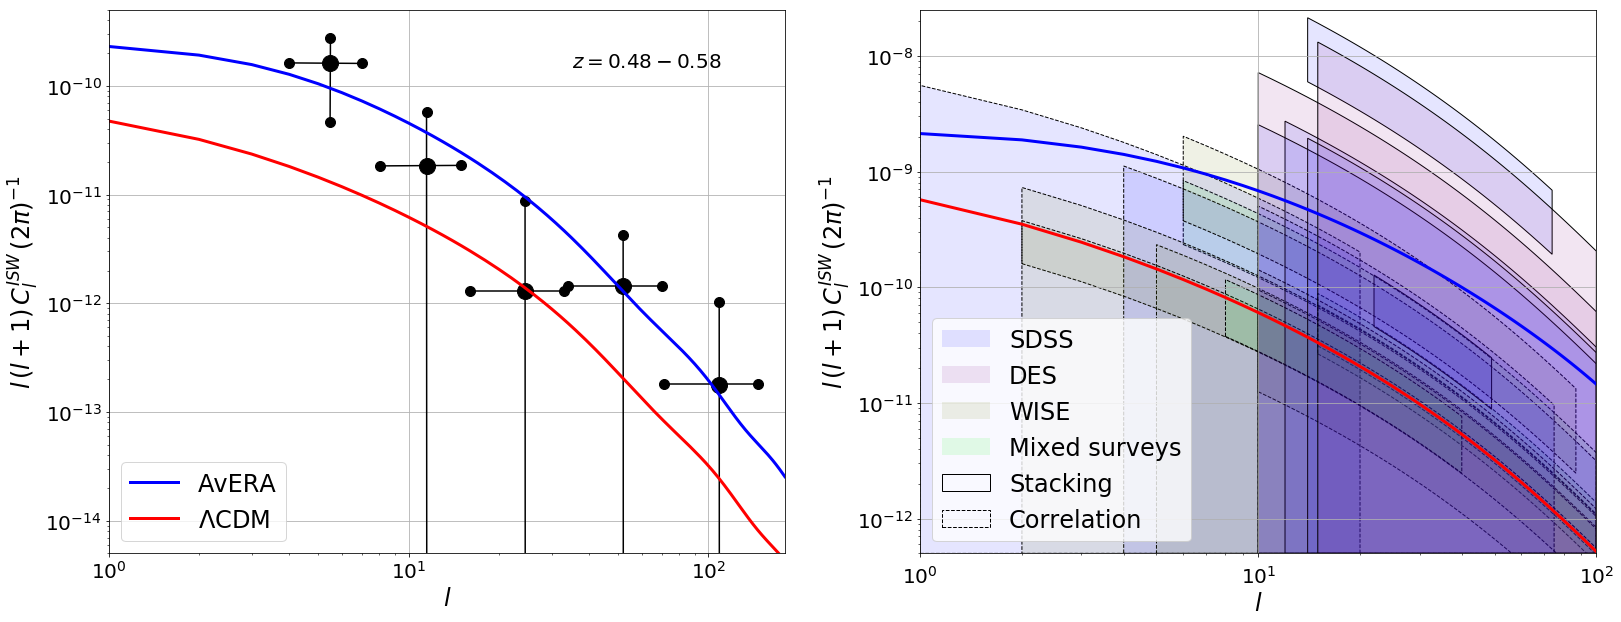

In [49]:
import matplotlib.patches as patches

sims=['BR','LCDM']
plotLabels=['AvERA','$\Lambda$CDM']

randomSamples=1000000
binNumber=500

lowBound=5e-13

fig = plt.figure(figsize=(26.66,10))

axs=[]

axs.append(fig.add_subplot(121))
axs.append(fig.add_subplot(122))

for ax in [axs[0]]:

    ax.set_xlabel('$l$', fontsize=24)
    ax.set_ylabel('$l \, (l+1) \, C^{ISW}_l \, (2\pi)^{-1}$', fontsize=24)
    ax.grid(True)
    ax.set_xlim(1,180)
    ax.set_ylim(5e-15,5e-10)

    ax.text(35,1.5e-10,'$z=0.48-0.58$', fontsize=20)

    ax.loglog(granettISWbVals[:,0],granettISWbVals[:,1]/1e12, 'ko', markersize=16)
    for i in range(valueNum):
        ax.loglog(granettISWbError[(2*i):(2*i+2),0],granettISWbError[(2*i):(2*i+2),1]/1e12, '-ko', markersize=10)
        ax.loglog(granettISWbError2[(2*i):(2*i+2),0],granettISWbError2[(2*i):(2*i+2),1]/1e12, '-ko', markersize=10)
    
    for i in range(len(sims)):

        ax.loglog(lVect_short,C_l_scaled_sim_b_short[i], '-', color=simColors[i], linewidth=3.0, label=plotLabels[i])


    ax.tick_params(axis='both', labelsize=20)

    ax.legend(shadow=False, fancybox=True, fontsize=24, loc=3)


for ax in [axs[1]]: 

    ax.add_patch(patches.Rectangle((-1e10,-1e10), #Bottom left coordinate
                                   0.1, #Width
                                   0.1, #Height
                                   alpha=alphaValue,
                                   facecolor=sdssColor,
                                   fill=True,
                                   label='SDSS'))

    ax.add_patch(patches.Rectangle((-1e10,-1e10), #Bottom left coordinate
                                   0.1, #Width
                                   0.1, #Height
                                   alpha=alphaValue,
                                   facecolor=desColor,
                                   fill=True,
                                   label='DES'))

    ax.add_patch(patches.Rectangle((-1e10,-1e10), #Bottom left coordinate
                                   0.1, #Width
                                   0.1, #Height
                                   alpha=alphaValue,
                                   facecolor=wiseColor,
                                   fill=True,
                                   label='WISE'))

    ax.add_patch(patches.Rectangle((-1e10,-1e10), #Bottom left coordinate
                                   0.1, #Width
                                   0.1, #Height
                                   alpha=alphaValue,
                                   facecolor=mixedColor,
                                   fill=True,
                                   label='Mixed surveys'))
    
    if stackingEdgeColor is not None:
        ax.add_patch(patches.Rectangle((-1e10,-1e10), #Bottom left coordinate
                                       0.1, #Width
                                       0.1, #Height
                                       alpha=1.0,
                                       edgecolor=stackingEdgeColor,
                                       fill=False,
                                       linewidth=1.0,
                                       lineStyle=stackingEdgeStyle,
                                       label='Stacking'))


    if corrEdgeColor is not None:
        ax.add_patch(patches.Rectangle((-1e10,-1e10), #Bottom left coordinate
                                       0.1, #Width
                                       0.1, #Height
                                       alpha=1.0,
                                       edgecolor=corrEdgeColor,
                                       fill=False,
                                       linewidth=1.0,
                                       lineStyle=corrEdgeStyle,
                                       label='Correlation'))
    
    for i in range(len(AValues)):
        
        ASamples=np.random.normal(loc=AValues[i][0],scale=AValues[i][1],size=randomSamples)
        
        #hpdci=computeHPDCI(ASamples**2,bins=binNumber)
        cimedian=computeCIMedian(ASamples**2,bins=binNumber)        
        
        ell = []
        clLow = []
        clHigh = []
        
        for l in np.arange(lRanges[i][0],lRanges[i][1]+1,dtype=np.int32):
            
            ind=np.where(lVect==l)[0]
            if len(ind)>0: #l=0,1 is missing from CMB power spectrum
                
                ell.append(lVect[ind[0]])
                
                if (C_l_scaled_sim_b[1][ind[0]]*cimedian[0])<lowBound:
                    
                    clLow.append(lowBound)
                    
                else:
                    
                    clLow.append( C_l_scaled_sim_b[1][ind[0]]*cimedian[0] )
                
                clHigh.append(C_l_scaled_sim_b[1][ind[0]]*cimedian[1] )

        
        xyPolygon=[]
        
        for j in range(len(ell)):

            xyPolygon.append([ell[j], clLow[j]])

        for j in reversed(range(len(ell))):

            xyPolygon.append([ell[j], clHigh[j]])

        j=0
        xyPolygon.append([ell[j], clLow[j]])

        xyPolygon=np.array(xyPolygon)


        ax.add_patch(patches.Polygon(xyPolygon,
                                     closed=True,
                                     alpha=alphaValue,
                                     facecolor=facecolors[i],
                                     fill=True))

        if (edgecolors[i] is not None):
            
            ax.add_patch(patches.Polygon(xyPolygon,
                                         closed=True,
                                         alpha=1.0,
                                         edgecolor=edgecolors[i],
                                         fill=False,
                                         linewidth=1.0,
                                         lineStyle=edgestyles[i]))

    
    for i in range(len(sims)):
        ax.loglog(lVect,C_l_scaled_sim_b[i],linewidth=3.0, color=simColors[i])


    ax.set_xlabel('$l$', fontsize=24)
    ax.set_ylabel('$l \, (l+1) \, C^{ISW}_l \, (2\pi)^{-1}$', fontsize=24)
    ax.grid(True)
            
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(axis='x', pad=8)   


axs[1].set_xlim([1,100])
axs[1].set_ylim([lowBound,2.5e-8])
#axs[1].set_yticks(np.arange(0,4.1e-9,1e-9))
                  
axs[1].legend(shadow=False, fancybox=True, fontsize=24, loc=3)

fig.savefig('fig/newNotebook_ISWPowerLiterature_CI_Ver6.pdf', bbox_inches='tight')

# ISW map plot

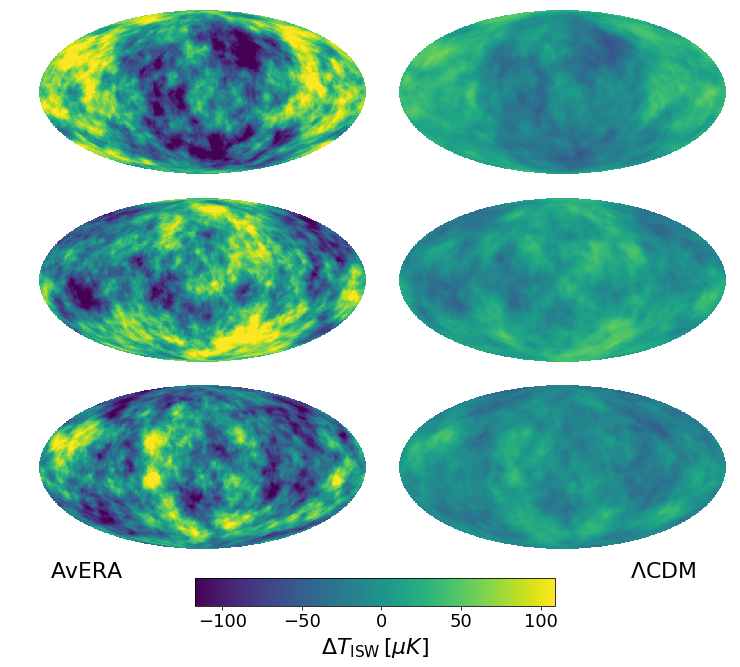

In [50]:
sims=['BR','LCDM']
simLabels=['AvERA','LCDM']
plotLabels=['AvERA','$\Lambda$CDM']


outRedshiftList=[0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0,6.0,7.0,8.0]

startPointNum = 3 

simulationTypes = 3

healPixResolution=64

scaleMultiplier=1e6

isLinear=True
simulationType=2

if isLinear:
    tag='linear_'
else:
    tag=''   


if simulationType==0:

    inPath= 'data/LC_results/'
    outPath= 'data/ISW_map/'

    outRedshiftListFull=outRedshiftList+[8.71]

elif simulationType==1:

    inPath= 'data/LC_results_XXL/'
    outPath= 'data/ISW_map/XXL_'

    outRedshiftListFull=outRedshiftList+[8.55]
    
elif simulationType==2:

    inPath= 'data/LC_results_XXL_lin/'
    outPath= 'data/ISW_map_lin/XXL_'

    outRedshiftListFull=outRedshiftList+[8.55]

zId=len(outRedshiftListFull)-1
   

fig = plt.figure(figsize=(len(sims)*5,startPointNum*2.6))

#fig.suptitle('ISW integrated to z = '+str(outRedshiftListFull[zId]), fontsize="20")

(rangeMin,rangeMax)=(1e10,-1e10)

for startID in range(startPointNum):

    for i in range(len(sims)):

        H0_SI=cosmoContainerDict[sims[i]].H0_SI_

        omega_m=cosmoContainerDict[sims[i]].omega_m_
         
        massPrefactor1=3.0*(H0_SI**2)*omega_m
        massPrefactor2=8.0*math.pi*G_const*pointMassCount*M_pointmass*M_Sun/(boxSize*MpcInMeters)**3
        
        deltaT_matrix=np.loadtxt(outPath+'deltaT_'+tag+sims[i]+'_'+str(startID)+'.txt')*(massPrefactor1/massPrefactor2)

        (localRangeMin,localRangeMax)=numpy.percentile(deltaT_matrix[:,zId+2],[3,97])

        rangeMin=min(rangeMin,localRangeMin)
        rangeMax=max(rangeMax,localRangeMax)

for startID in range(startPointNum):

    for i in range(len(sims)):

        H0_SI=cosmoContainerDict[sims[i]].H0_SI_

        omega_m=cosmoContainerDict[sims[i]].omega_m_
         
        massPrefactor1=3.0*(H0_SI**2)*omega_m
        massPrefactor2=8.0*math.pi*G_const*pointMassCount*M_pointmass*M_Sun/(boxSize*MpcInMeters)**3
        
        #ax = fig.add_subplot(startPointNum,len(sims),startID*len(sims)+i+1)

        deltaT_matrix=np.loadtxt(outPath+'deltaT_'+tag+sims[i]+'_'+str(startID)+'.txt')*(massPrefactor1/massPrefactor2)
        
        unitStr='$\Delta T_{\mathrm{ISW}} \, [\mu K]$'       
        
        #plt.axes(ax)
        hp.mollview(deltaT_matrix[:,zId+2]*scaleMultiplier,
                    title='',
                    unit='',
                    cbar=False,
                    #hold=True,
                    min=rangeMin*scaleMultiplier,
                    max=rangeMax*scaleMultiplier,
                    sub=(startPointNum,len(sims),startID*len(sims)+i+1))

        if startID==2 and i==0:
            
            im = fig.axes[-1].get_images()[0]
        
            colorAx = fig.add_axes([0.25, -0.1, 0.5, 0.05])

            cb=fig.colorbar(im, cax=colorAx, orientation='horizontal')
            
            cb.ax.text(0.5,-1.5,unitStr,fontsize=22,transform=cb.ax.transAxes,ha='center',va='center')
            cb.ax.tick_params(labelsize=18)
    
fig.text(0.1,-0.05,plotLabels[0], ha='center', fontsize=22)
fig.text(0.9,-0.05,plotLabels[1], ha='center', fontsize=22)

fig.savefig('fig/newNotebook_ISWmap.pdf', bbox_inches='tight')